In [369]:
import os
import glob as glob
import timecorr as tc
import hypertools as hyp
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.decomposition import PCA, IncrementalPCA
import seaborn as sns
import statsmodels.api as sm 
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
import scipy.interpolate
import statsmodels
import matplotlib.pyplot as plt
%matplotlib inline  
import timecorr as tc
from timecorr.helpers import isfc, wisfc, mean_combine, corrmean_combine
import supereeg as se

In [2]:
def rbf(centers, widths, locs):
    """
    Radial basis function
    Parameters
    ----------
    centers : ndarray
        rbf coordinates (one row per RBF)
    widths : ndarray
        RBF radii
    locs : ndarray
        locations to evaluate the RBFs (one row per location)
        
    Returns
    ----------
    results : ndarray
        Matrix of RBF weights for each RBF (row), at each location (column)
    """    
    weights = np.exp(np.divide(-cdist(locs, centers, metric='euclidean') ** 2, np.tile(np.array(widths, ndmin=2), [locs.shape[0], 1])))
    return weights.T

In [3]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [4]:
def reduce_list(x, model):
    split = np.cumsum([len(xi) for xi in x])[:-1]
    x_r = np.vsplit(model.fit_transform(np.vstack(x)), split)
    if len(x) > 1:
        return [xi for xi in x_r]
    else:
        return [x_r[0]]

In [5]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

In [371]:
def n_derivative(arr, degree=1):
    """Compute the n-th derivative."""
    result = arr.copy()
    for i in range(degree):
        result = np.gradient(result)
    return result


def close_zero(arr, threshold=1e-4):
    return (abs(arr) < threshold)

def maxima_2(arr):
    return close_zero(n_derivative(arr, 2)) & (n_derivative(arr, 3) > 0)


In [6]:
datadir = os.path.join(os.getenv('HOME'), 'Desktop', 'pca_env', 'pca_paper', 'pieman', 'data')


In [7]:
figdir = '../figs'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [8]:
nii_bo_dir = '../../data/niis'

In [9]:
pca_nii_bo_dir = os.path.join(nii_bo_dir, 'pcas')
if not os.path.exists(pca_nii_bo_dir):
    os.makedirs(pca_nii_bo_dir)

In [10]:
neurosynth_dir ='../figs/neurosynth_data/'
if not os.path.exists(neurosynth_dir):
    os.mkdir(neurosynth_dir)

In [11]:
n_f_dir = os.path.join(neurosynth_dir, 'figs')
if not os.path.exists(n_f_dir):
    os.mkdir(n_f_dir)
nii_dir = os.path.join(neurosynth_dir, 'niis')
if not os.path.exists(nii_dir):
    os.mkdir(nii_dir)
txt_dir = os.path.join(neurosynth_dir, 'txts')
if not os.path.exists(txt_dir):
    os.mkdir(txt_dir)
p_txt_dir = os.path.join(txt_dir, 'parsed_txts')
if not os.path.exists(p_txt_dir):
    os.mkdir(p_txt_dir)

In [66]:
network_dir = '../../data/yeo_networks'

In [12]:
ddir = '../../data/'

In [13]:
#figdir = '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/figs'

In [14]:
#results_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')
results_dir = os.path.join('../../data/', 'results')

In [15]:
posterior = loadmat(os.path.join(ddir, 'pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

In [16]:
template = se.helpers._gray(res=2)

In [17]:
network_list = ['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention',
                'Limbic ', 'Frontoparietal', 'Default']


In [18]:
factors=700

In [19]:
if factors == 100:
    pieman_name = '../../data/pieman_ica100.mat'
else:
    pieman_name = '../../data/pieman_data.mat'

pieman_conds = ['intact', 'paragraph', 'word', 'rest']

In [20]:
pieman_data = loadmat(pieman_name)

In [21]:
debug = False

In [22]:
if debug:
    data = []
    conds = []
    for c in pieman_conds:
        next_data = list(map(lambda i: pieman_data[c][:, i][0][:30, :10], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

else:

    data = []
    conds = []
    for c in pieman_conds:
        if c == 'paragraph':
            if factors == 700:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
            else:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 0)[0]))
        else:
            next_data = list(map(lambda i: pieman_data[c][:, i][0], np.arange(pieman_data[c].shape[1])))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

In [23]:
data = np.array(data)
conds = np.array(conds)

In [68]:
n_nets = 7

In [69]:
yeo_colors = pd.read_fwf(os.path.join(network_dir, 'Yeo2011_' + str(n_nets) + 'Networks_ColorLUT.txt'))
yeo_colors.columns = ["inds", "networks", "x", "y", "z", "labels"]


In [70]:
if n_nets == 17:
    yeo_color_labels = ['visual peripheral', 'visual central', 'somatomotor A', 'somatomotor B', 'dorsal attention A', 
                        'dorsal attention B', 'ventral attention', 'salience', 'limbic A', 'limbic B', 'control C', 
                        'control A', 'control B', 'default D (auditory)', 'default C', 'default A', 'default B']
elif n_nets == 7:
    yeo_color_labels = ['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 'Limbic ',
                        'Frontoparietal', 'Default']
    
yeo_colors['labels'] = yeo_color_labels

In [71]:

color_stacked = np.array([])
for i in np.arange(0,n_nets+1):
    if color_stacked.shape[0]==0:
        color_stacked = yeo_colors[yeo_colors.inds==i][['x', 'y', 'z']].values
    else:
        color_stacked = np.vstack((color_stacked, yeo_colors[yeo_colors.inds==i][['x', 'y', 'z']].values))
color_stacked = color_stacked/255

## pieman pca decoding

In [212]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100'

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/intact_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/paragraph_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/rest_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/word_Visual.csv']


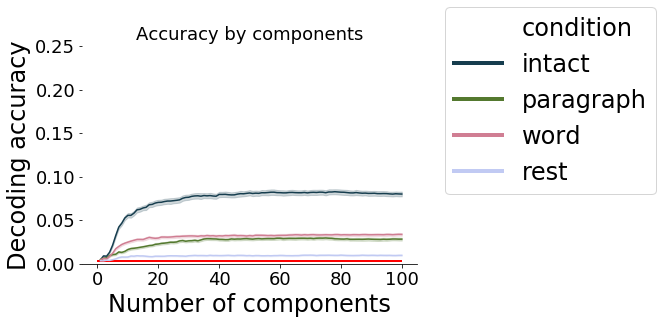

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/intact_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/paragraph_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/rest_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100/word_Somatomotor.csv']


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

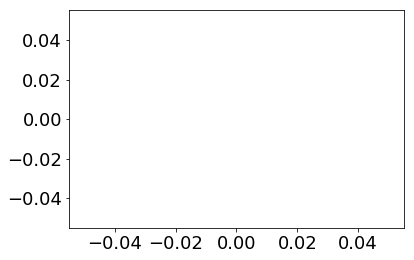

In [84]:
for n in np.arange(len(network_list)):
    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    print(conds)
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)
    
    outfile = os.path.join(figdir, 'Accuracy_by_components_' + network_list[n] + '.pdf')
    
    fig, ax = plt.subplots()
    sns.lineplot(x="dims", y="accuracy",
                 hue="condition",
                 data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
    sns.despine(ax=ax, left=True)
    ax.set_title('Accuracy by components')
    ax.set_ylabel('Decoding accuracy',fontsize=24)
    ax.set_xlabel('Number of components',fontsize=24)
    ax.set_ylim(0, .25)
    ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
    #ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
    l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    for line in l.get_lines():
        line.set_linewidth(4.0)
    #fig.savefig(outfile, bbox_inches='tight')
    plt.show()
    plt.clf()

In [177]:
def func(x, a, b, c, d, g):

    return (((a-d)/((1+((x/c)** b))**g)) + d )

In [178]:
hill_all = np.zeros((7, 4))
maxs_all = np.zeros((7, 4))
spearmans_all= np.zeros((7, 4))

In [179]:
for n in np.arange(len(network_list)):

    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)


    ydata = full_data[full_data['condition']=='intact'].groupby('dims')['accuracy'].mean().as_matrix()
    xdata = np.array(full_data[full_data['condition']=='intact'].groupby('dims')['accuracy'].mean().index)

    popt, pcov = curve_fit(func, xdata, ydata, maxfev=4000)
    
    hill_all[n, 0] = popt[1]
    
    max_i = ydata.max()
    
    maxs_all[n, 0] = max_i

    max_loc = np.where(ydata==max_i)[0][0]

    max_p = full_data[full_data['condition']=='paragraph'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
    max_w = full_data[full_data['condition']=='word'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
    max_r = full_data[full_data['condition']=='rest'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]


    spearmans_all[n, 0] = spearmanr([4,3,2,1],[max_i,max_p,max_w,max_r])[0]


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


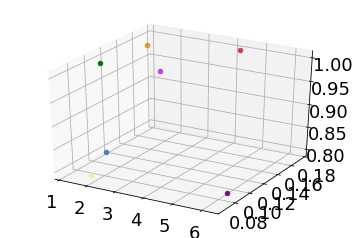

In [180]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for e in np.arange(n_nets):
    
    ax.scatter(hill_all[e, 0],maxs_all[e, 0],spearmans_all[e, 0], color=color_stacked[e])

In [213]:
hill_all = np.zeros((4, 7, 4))
maxs_all = np.zeros((4, 7, 4))

In [214]:
for n in np.arange(len(network_list)):

    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

            
    conditions = ['intact', 'paragraph', 'word', 'rest']


    for e, c in enumerate(conditions):


        ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
        xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

        popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)
        
        i = 0
        
        hill_all[e, n, i] = popt[1]

        maxs_all[e, n, i] = ydata.max()


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [27]:
# outfile = os.path.join(figdir, 'Accuracy_by_components.pdf')

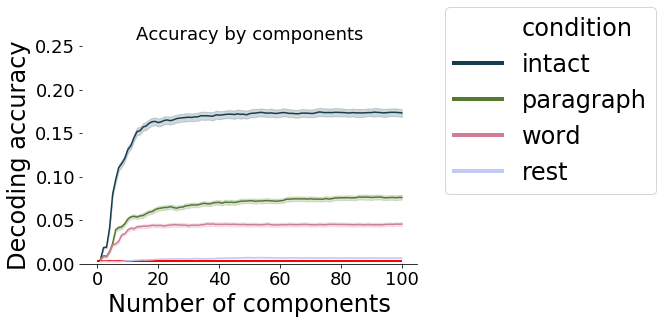

In [28]:
# fig, ax = plt.subplots()
# sns.lineplot(x="dims", y="accuracy",
#              hue="condition",
#              data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
# sns.despine(ax=ax, left=True)
# ax.set_title('Accuracy by components')
# ax.set_ylabel('Decoding accuracy',fontsize=24)
# ax.set_xlabel('Number of components',fontsize=24)
# ax.set_ylim(0, .25)
# ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
# #ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
# l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
# for line in l.get_lines():
#     line.set_linewidth(4.0)
# fig.savefig(outfile, bbox_inches='tight')

In [29]:
# full_data['diff'] = full_data.groupby(['condition', 'iteration', 'folds'])['accuracy'].diff(2)/2

In [30]:
# fig, ax = plt.subplots()
# sns.lineplot(x="dims", y='diff',
#              hue="condition",
#              data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])

In [31]:

# lm = sns.lmplot(x="dims", y="diff",
#              hue="condition",
#              data=full_data, scatter_kws={"alpha":0.0,"s":20}, ci=95, palette="cubehelix", logistic=True, 
#            hue_order=['intact', 'paragraph', 'word', 'rest'])
# axes = lm.axes
# axes[0,0].set_ylim(0,.02)
# axes[0,0].set_xlim(1,100)


In [215]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100'

In [132]:

for n in np.arange(len(network_list)):
    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)
            
    for i in range(3):
        full_data_temp = full_data[full_data['third']==i]

        ydata = full_data_temp[full_data_temp['condition']=='intact'].groupby('dims')['accuracy'].mean().as_matrix()
        xdata = np.array(full_data_temp[full_data_temp['condition']=='intact'].groupby('dims')['accuracy'].mean().index)

        popt, pcov = curve_fit(func, xdata, ydata, maxfev=8000)
        
        hill_all[n, i+1] = popt[1]

        max_i = ydata.max()

        maxs_all[n, i+1] = max_i

        max_loc = np.where(ydata==max_i)[0][0]

        max_p = full_data_temp[full_data_temp['condition']=='paragraph'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
        max_w = full_data_temp[full_data_temp['condition']=='word'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
        max_r = full_data_temp[full_data_temp['condition']=='rest'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]


        spearmans_all[n, i+1] = spearmanr([4,3,2,1],[max_i,max_p,max_w,max_r])[0]


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [ ]:
for n in np.arange(len(network_list)):
    

    resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100'

    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

            
    conditions = ['intact', 'paragraph', 'word', 'rest']

    hill_all = np.zeros((4, 4))
    maxs_all = np.zeros((4, 4))


    for e, c in enumerate(conditions):


        ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
        xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

        popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)
        

        f = scipy.interpolate.interp1d(xdata, func(xdata, *popt), 'cubic')
        y = f(xdata)

        hill_all[e, 0] = xdata[maxima_2(y)].min()

        maxs_all[e, 0] = func(xdata[maxima_2(y)].min(), *popt)

In [731]:
close_zero(n_derivative(y, 3))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [815]:
def n_derivative(arr, degree=1):
    """Compute the n-th derivative."""
    result = arr.copy()
    for i in range(degree):
        result = np.gradient(result)
    return result


def close_zero(arr, threshold=1e-4):
    return (abs(arr) < threshold)

def maxima_2(arr):
    
    
    bl = close_zero(n_derivative(arr, 2))
    b2 = close_zero(n_derivative(arr, 3))
    #bl[0:3]=False
    #bl[90:]=False
    #btry = close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)))
    
    #try_it = bl & (n_derivative(arr, 3) > 0)
    #try_it = ~close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)))& (n_derivative(arr, 3) > 1e-8)
    #try_it = btry & (n_derivative(arr, 3) > 1e-10)
    try_it = bl & b2 & (n_derivative(arr, 3) > 0)
    if not np.any(try_it):
        try_it[0]=True
    
    return try_it


In [975]:
def n_derivative(arr, degree=1):
    """Compute the n-th derivative."""
    result = arr.copy()
    for i in range(degree):
        result = np.gradient(result)
    return result


def close_zero(arr, threshold=1e-4):
    return (abs(arr) < threshold)

def maxima_2(arr):
    
    
    bl = close_zero(n_derivative(arr, 2))
    b2 = close_zero(n_derivative(arr, 3))
    #bl[0:3]=False
    #bl[90:]=False
    #btry = close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)))
    
    #try_it = bl & (n_derivative(arr, 3) > 0)
    #try_it = ~close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)))& (n_derivative(arr, 3) > 1e-8)
    #try_it = btry & (n_derivative(arr, 3) > 1e-10)
    try_it = bl & b2 & (n_derivative(arr, 3) > 0)
    
    #try_it = bl & b2 & close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)), threshold=1e-4)
    
    for i, e in reversed(list(enumerate(try_it))):

        if e == False:
            k = i
            break
            
            
    if k > 90: 
        try_it = bl & b2 & close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)), threshold=1e-4)
        for i, e in reversed(list(enumerate(try_it))):

            if e == False:
                k = i
                break
    if k > 90: 
        try_it = bl & b2 & close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)), threshold=1e-5)
        for i, e in reversed(list(enumerate(try_it))):

            if e == False:
                k = i
                break
                
    if k > 90: 
        try_it = bl & b2 & close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)), threshold=1e-6)
        for i, e in reversed(list(enumerate(try_it))):

            if e == False:
                k = i
                break 
                
    if k > 90: 
        try_it = bl & b2 & close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)), threshold=1e-7)
        for i, e in reversed(list(enumerate(try_it))):

            if e == False:
                k = i
                break  
                
    return k


In [952]:
close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)), threshold=1e-5)

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [766]:
arr = y
try_it = ~close_zero(np.abs(n_derivative(arr, 3)-n_derivative(arr, 2)))& (n_derivative(arr, 3) > 1e-8)

In [929]:

bl = close_zero(n_derivative(y, 2))
b2 = close_zero(n_derivative(y, 3))
try_it = bl & b2 & (n_derivative(y, 3) > 0)


In [930]:
b1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [931]:
b2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [933]:
try_it

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [932]:
(n_derivative(y, 3) > 0)

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [927]:
bl & b2 & (n_derivative(y, 3) > 0)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [851]:
try_it

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [857]:
len(y)

100

In [856]:
np.arange(1, len(arr)+1)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [849]:
xdata>popt[2]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [846]:
n_derivative(y, 3)

array([ 5.67176593e-07,  9.45780289e-07,  1.55037553e-06,  2.03803682e-06,
        2.55897984e-06,  3.07083353e-06,  3.56357066e-06,  4.02402776e-06,
        4.43551071e-06,  4.77770914e-06,  5.02699472e-06,  5.15719935e-06,
        5.14096097e-06,  4.95168667e-06,  4.56611286e-06,  3.96733956e-06,
        3.14809007e-06,  2.11381564e-06,  8.85157648e-07, -5.00766320e-07,
       -1.99073698e-06, -3.51778656e-06, -5.00557065e-06, -6.37444729e-06,
       -7.54859795e-06, -8.46325516e-06, -9.07099484e-06, -9.34615202e-06,
       -9.28671585e-06, -8.91349112e-06, -8.26677637e-06, -7.40119722e-06,
       -6.37956616e-06, -5.26668373e-06, -4.12386758e-06, -3.00475129e-06,
       -1.95260590e-06, -9.99170255e-07, -1.64775573e-07,  5.40564636e-07,
        1.11546171e-06,  1.56518928e-06,  1.89971738e-06,  2.13192836e-06,
        2.27612104e-06,  2.34684467e-06,  2.35805697e-06,  2.32257077e-06,
        2.25173880e-06,  2.15532235e-06,  2.04149249e-06,  1.91691979e-06,
        1.78691689e-06,  

In [836]:
try_it

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [837]:
b1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [838]:
b2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

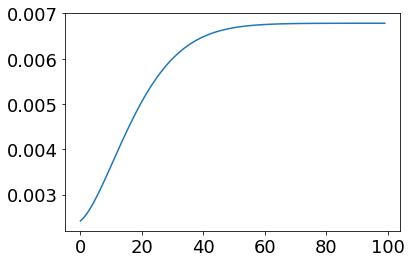

In [934]:
plt.plot(y)

In [845]:
popt[2]

36.35640598264216

In [843]:
func(popt[3], *popt)

0.01567642818423794

In [913]:
maxima_2(y)

99

In [883]:
maxima_2(y)

38

In [831]:
xdata[~try_it].min()

20

In [787]:
(n_derivative(y, 3) > 1e-10)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [746]:
n_derivative(y, 3)

array([ 7.74053283e-05,  8.24513371e-05,  4.77253317e-05, -3.75610284e-06,
       -2.59816768e-05, -4.53322342e-05, -6.06534568e-05, -7.07343594e-05,
       -7.47636013e-05, -7.25640198e-05, -6.46703528e-05, -5.22642843e-05,
       -3.69904288e-05, -2.06958668e-05, -5.14899669e-06,  8.20561732e-06,
        1.84119184e-05,  2.50638092e-05,  2.82656057e-05,  2.85150655e-05,
        2.65452013e-05,  2.31630437e-05,  1.91161411e-05,  1.50046199e-05,
        1.12426109e-05,  8.06160396e-06,  5.54190699e-06,  3.65707836e-06,
        2.31872013e-06,  1.41349360e-06,  8.28862615e-07,  4.67697928e-07,
        2.54007757e-07,  1.32799182e-07,  6.68421579e-08,  3.23913645e-08,
        1.51123023e-08,  6.78795290e-09,  2.93512132e-09,  1.22167266e-09,
        4.89417801e-10,  1.88689966e-10,  7.00010761e-11,  2.49853723e-11,
        8.57880867e-12,  2.83309140e-12,  8.99737750e-13,  2.74738565e-13,
        8.06490291e-14,  2.27543678e-14,  6.17041140e-15,  1.60982339e-15,
        4.02455846e-16,  

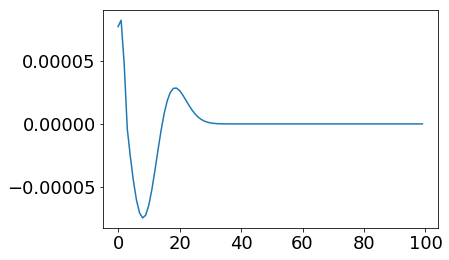

In [745]:
plt.plot(n_derivative(y, 3))

In [743]:
close_zero(np.abs(n_derivative(y, 3)-n_derivative(y, 2)))

array([ True, False, False, False, False, False, False, False, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [841]:
y ==popt[3]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

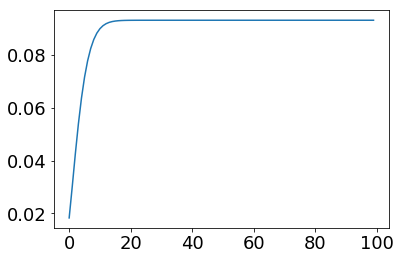

In [918]:
plt.plot(y)

In [869]:
xdata[maxima_2(y)].min()

1

In [679]:
n_derivative(y, 3).max()-n_derivative(y, 3).min()/2

5.682404735850809e-06

In [694]:
norm_2 = 2 * ((n_derivative(y, 2) - n_derivative(y, 2).min()) / (n_derivative(y, 2).max() - n_derivative(y, 2).min()))-1

In [695]:
norm_3 = 2 *((n_derivative(y, 3) - n_derivative(y, 3).min()) / (n_derivative(y, 3).max() - n_derivative(y, 3).min()))-1

In [714]:
xdata[maxima_2(y)].max()

100

In [659]:
np.where(y == y.max())

(array([99]),)

In [608]:
close_zero(n_derivative(y, 3)-n_derivative(y, 2))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [660]:
b1 = close_zero(n_derivative(y, 2))

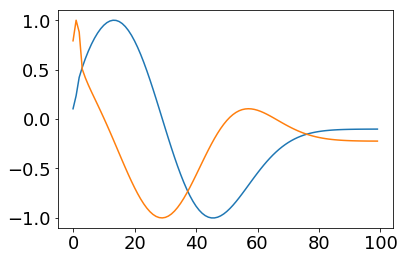

In [696]:
plt.plot(norm_2)
plt.plot(norm_3)

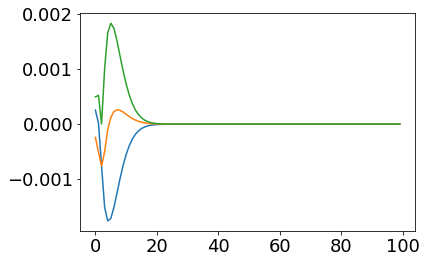

In [919]:
plt.plot(n_derivative(y, 2))
plt.plot(n_derivative(y, 3))
plt.plot(np.abs(n_derivative(y, 3)-n_derivative(y, 2)))

In [940]:
np.abs(n_derivative(y, 3)-n_derivative(y, 2))>

array([4.95948650e-04, 5.23199423e-04, 3.36652230e-06, 1.01230056e-03,
       1.65553314e-03, 1.83210382e-03, 1.74196851e-03, 1.51660282e-03,
       1.24204783e-03, 9.70525448e-04, 7.29793386e-04, 5.31103422e-04,
       3.75563952e-04, 2.58824963e-04, 1.74238126e-04, 1.14786029e-04,
       7.41125744e-05, 4.69560980e-05, 2.92245181e-05, 1.78834794e-05,
       1.07683518e-05, 6.38471115e-06, 3.72989575e-06, 2.14810875e-06,
       1.22021742e-06, 6.83969768e-07, 3.78473618e-07, 2.06823025e-07,
       1.11655328e-07, 5.95687900e-08, 3.14158219e-08, 1.63829139e-08,
       8.45010013e-09, 4.31189746e-09, 2.17727058e-09, 1.08815214e-09,
       5.38382226e-10, 2.63755554e-10, 1.27968724e-10, 6.14999822e-11,
       2.92812267e-11, 1.38139361e-11, 6.45842754e-12, 2.99283168e-12,
       1.37481693e-12, 6.26132826e-13, 2.82763396e-13, 1.26650426e-13,
       5.62501434e-14, 2.47839943e-14, 1.08437564e-14, 4.69069228e-15,
       2.01054451e-15, 8.65627015e-16, 3.67761377e-16, 1.61329283e-16,
      

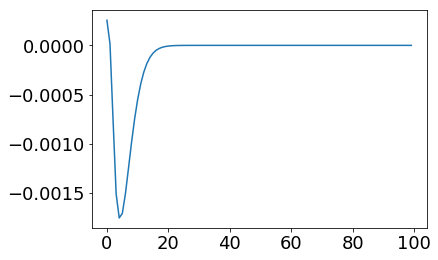

In [924]:
plt.plot(n_derivative(y, 2))

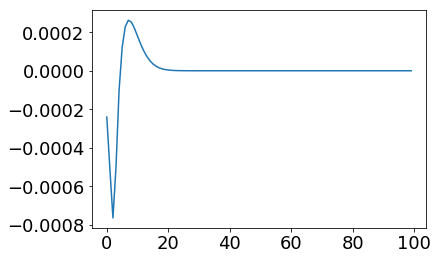

In [923]:
plt.plot(n_derivative(y, 3))

In [589]:
try_it = bl & (n_derivative(y, 3) > 0)

In [872]:
try_it

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [879]:
for i, e in reversed(list(enumerate(try_it))):

    if e == False:
        print(i)
        break


38


In [875]:
for i in try_it :
    print(i)
    if i == True : 
        flag = 1
        break
        print(i)

True


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [718]:
xdata[~maxima_2(y)].max()

24

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


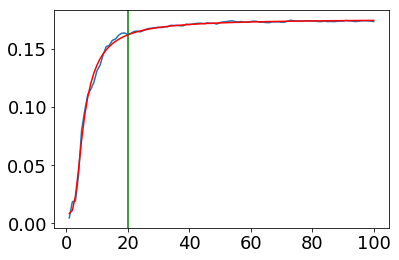

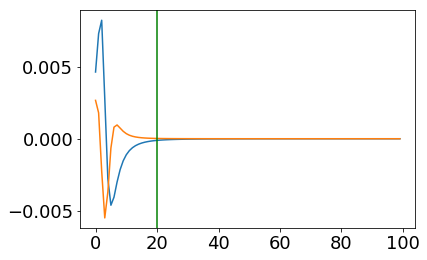

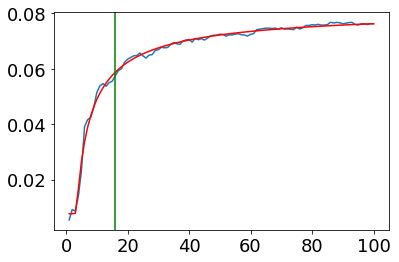

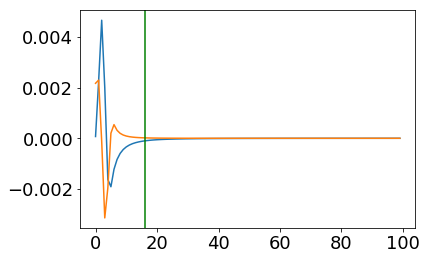

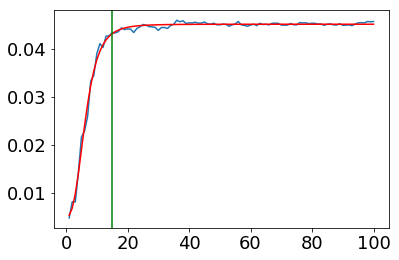

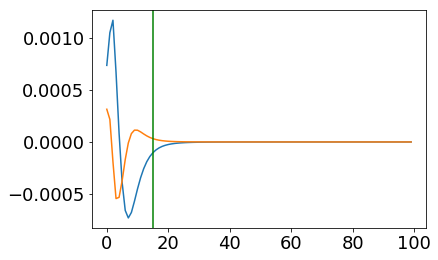

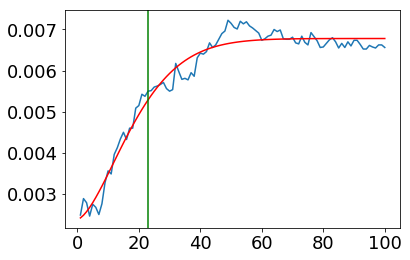

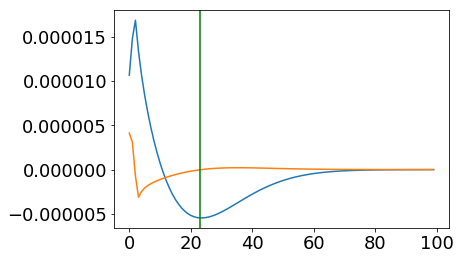

In [970]:
maxs_ns = np.zeros((7, 4, 4))
hills_ns = np.zeros((7, 4, 4))

hill_all = np.zeros((4, 4))
maxs_all = np.zeros((4, 4))

#for n in np.arange(len(network_list)):
for n in [6]:   

    resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100'

    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

            
    conditions = ['intact', 'paragraph', 'word', 'rest']

    hill_all = np.zeros((4, 4))
    maxs_all = np.zeros((4, 4))


    for e, c in enumerate(conditions):


        ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
        xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

        popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)
        

        f = scipy.interpolate.interp1d(xdata, func(xdata, *popt), 'cubic')
        y = f(xdata)

        hill_all[e, 0] = maxima_2(y)

        maxs_all[e, 0] = func(maxima_2(y), *popt)
        

        plt.plot(xdata, ydata)
        plt.plot(xdata, func(xdata, *popt), 'r-')
        plt.axvline(x=maxima_2(y), color='g', linestyle='-')
        #plt.axvline(x=xdata[maxima_2(y)].min(), color='g', linestyle='-')
        #plt.axvline(x=popt[2], color='black', linestyle='-')
        plt.show()
        plt.plot(n_derivative(y, 2))
        plt.plot(n_derivative(y, 3))
        plt.axvline(x=maxima_2(y), color='g', linestyle='-')

        
        plt.show()

In [737]:
xdata[~maxima_2(y)].max()

98

In [926]:
maxima_2(y)

23

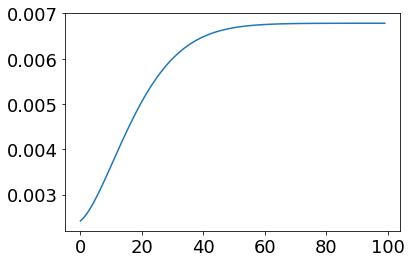

In [802]:
plt.plot(y)

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:80: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


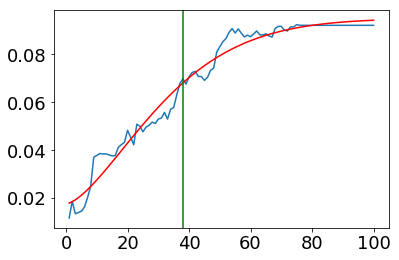

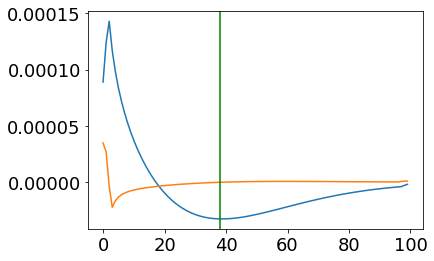

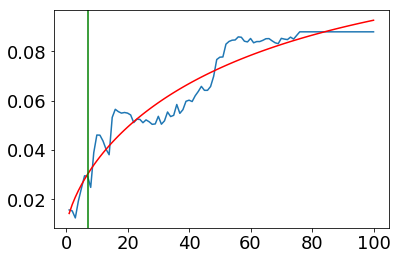

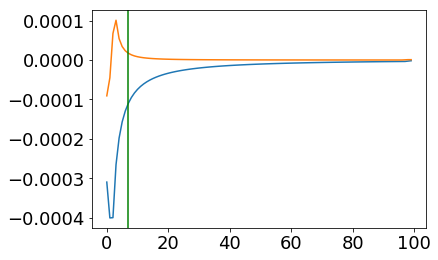

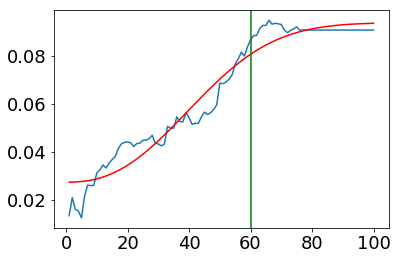

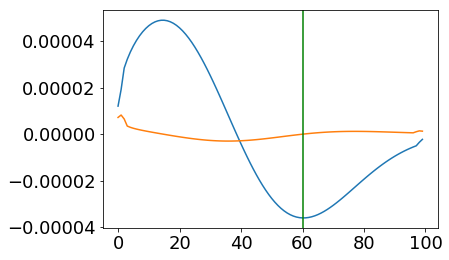

In [968]:

maxs_ns = np.zeros((7, 4, 4))
hills_ns = np.zeros((7, 4, 4))

hill_all = np.zeros((4, 4))
maxs_all = np.zeros((4, 4))

#for n in np.arange(len(network_list)):
for n in [4]:   

#     resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100'

#     conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
#     full_data = pd.DataFrame()
#     for c in conds:
#         data = pd.read_csv(c)
#         data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

#         if full_data.empty:
#             full_data = data
#         else:
#             full_data = full_data.append(data)

            
#     conditions = ['intact', 'paragraph', 'word', 'rest']

#     hill_all = np.zeros((4, 4))
#     maxs_all = np.zeros((4, 4))


#     for e, c in enumerate(conditions):


#         ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
#         xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

#         popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)
        

#         f = scipy.interpolate.interp1d(xdata, func(xdata, *popt), 'cubic')
#         y = f(xdata)

#         hill_all[e, 0] = xdata[maxima_2(y)].min()

#         maxs_all[e, 0] = func(xdata[maxima_2(y)].min(), *popt)
        
#         plt.plot(xdata, ydata)
#         plt.plot(xdata, func(xdata, *popt), 'r-')
#         plt.axvline(x=xdata[~maxima_2(y)].max(), color='g', linestyle='-')
#         plt.show()
        
#         plt.plot(n_derivative(y, 2))
#         plt.plot(n_derivative(y, 3))
#         plt.axvline(x=xdata[~maxima_2(y)].max(), color='g', linestyle='-')
#         plt.show()
        
    resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100'
    
    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

    #conditions = ['intact', 'paragraph', 'word', 'rest']
    conditions = ['intact']
    
    for i in np.arange(1, 4):
    #for i in [1]:
        full_data_temp = full_data[full_data['third']==i-1]

        for e, c in enumerate(conditions):


            ydata = full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
            xdata = np.array(full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().index)

            popt, pcov = curve_fit(func, xdata, ydata, maxfev=1000000)
    
            f = scipy.interpolate.interp1d(xdata, func(xdata, *popt), 'cubic')
            y = f(xdata)

            hill_all[e, i] = maxima_2(y)

            maxs_all[e, i] = func(maxima_2(y), *popt)

            plt.plot(xdata, ydata)
            plt.plot(xdata, func(xdata, *popt), 'r-')
            plt.axvline(x=maxima_2(y), color='g', linestyle='-')
            plt.show()
            plt.plot(n_derivative(y, 2))
            plt.plot(n_derivative(y, 3))
            #plt.axvline(x=xdata[~maxima_2(y)].max(), color='g', linestyle='-')
            plt.axvline(x=maxima_2(y), color='g', linestyle='-')
            plt.show()
            
    hills_ns[n, :, :] = hill_all
    
    maxs_ns[n, :, :] = maxs_all

In [829]:
xdata[maxima_2(y)].min()

1

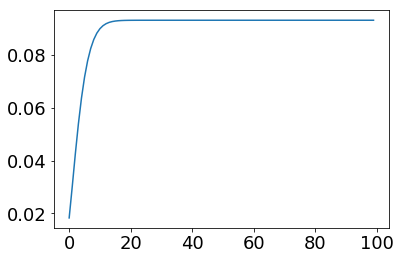

In [938]:
plt.plot(y)

In [828]:
maxima_2(y)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [313]:
verts = [list(zip([0]*4, [.2]*4, [n]*4))]

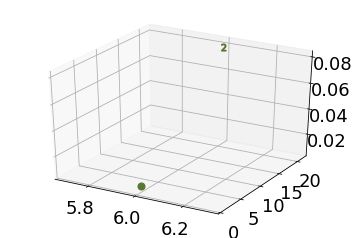

In [411]:
ax=plt.subplot(projection='3d')
for n in [6]:
    #for e, c in enumerate(conditions):
    for e in [1]:
        #for i in np.arange(2):
        for i in [0, 2]:
            ax.scatter(n, hills_ns[n, e, i], maxs_ns[n, e, i], 
                        marker=markers[i], s=50, color=colors[e])
plt.show()

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


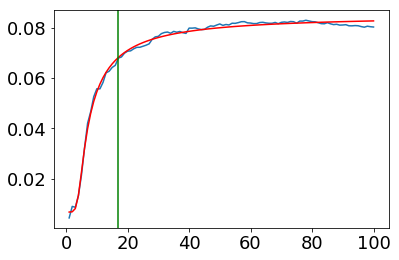

17
0
intact
3


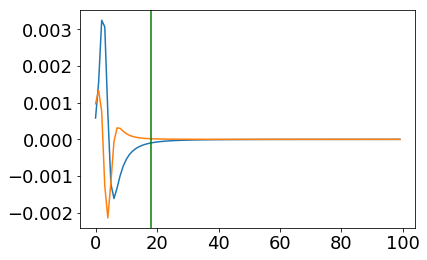

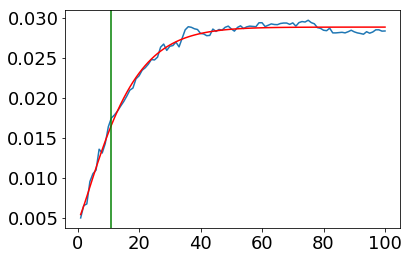

11
0
paragraph
3


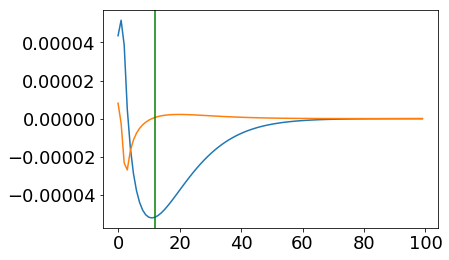

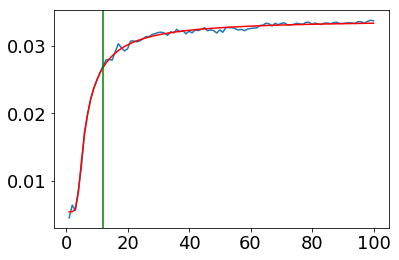

12
0
word
3


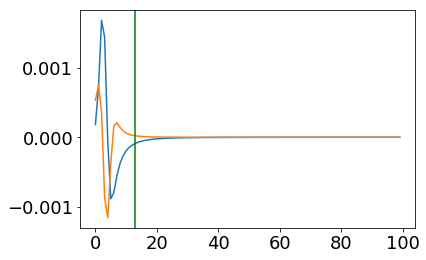

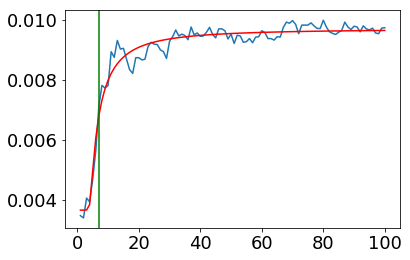

7
0
rest
3


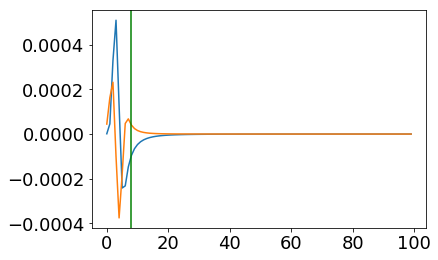

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


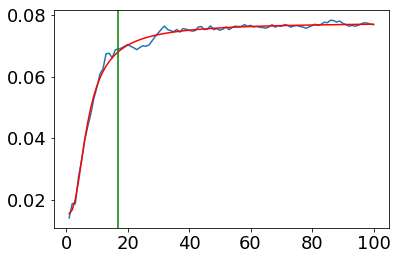

17
0
intact
1


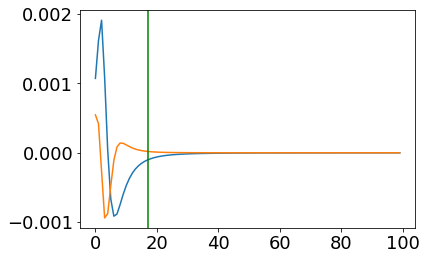

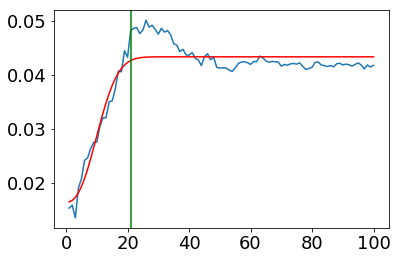

21
0
paragraph
1


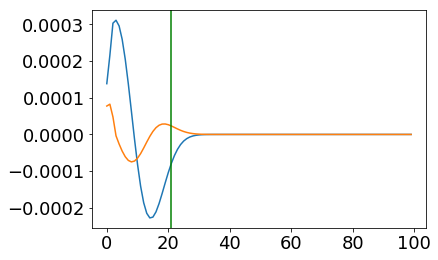

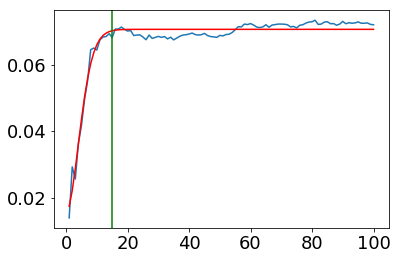

15
0
word
1


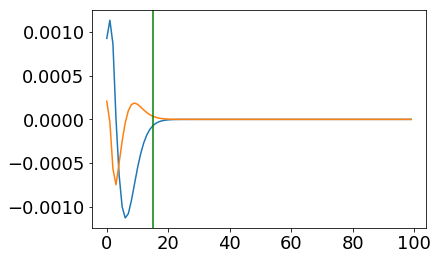

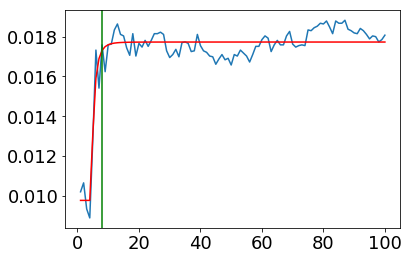

8
0
rest
1


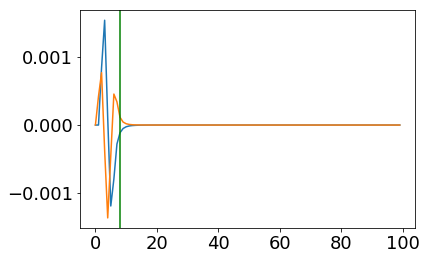

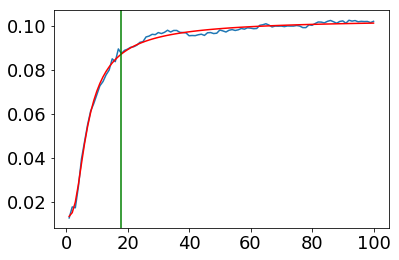

18
0
intact
2


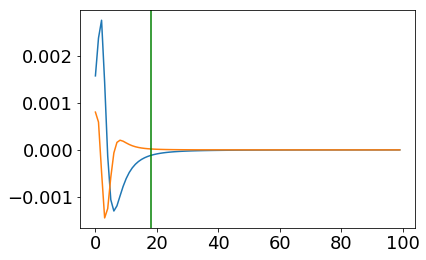

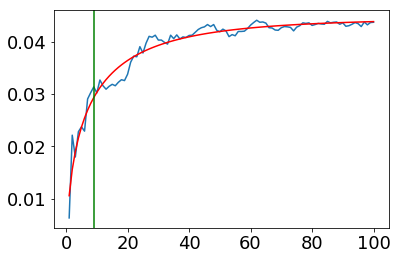

9
0
paragraph
2


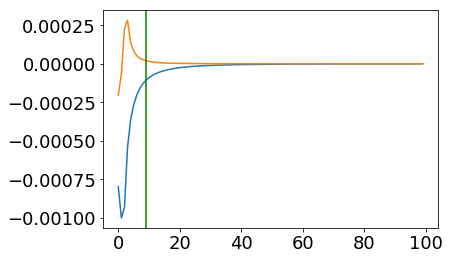

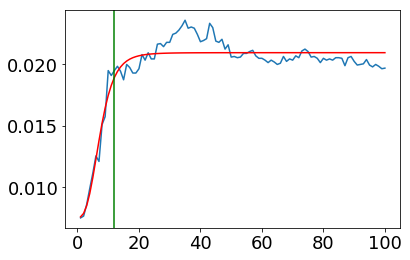

12
0
word
2


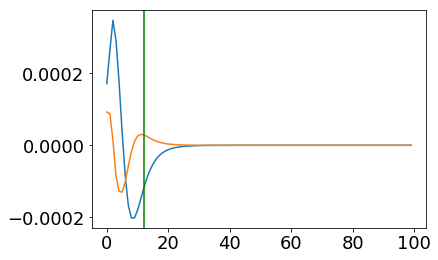

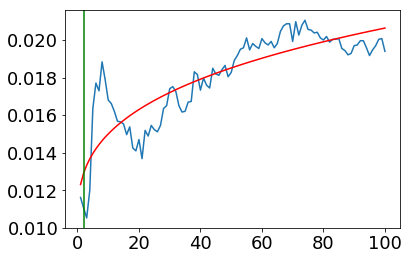

2
0
rest
2


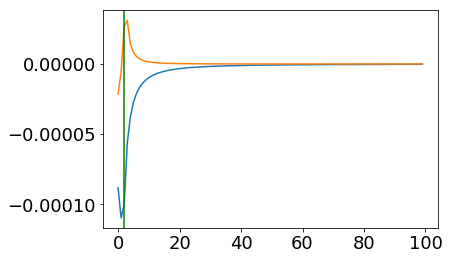

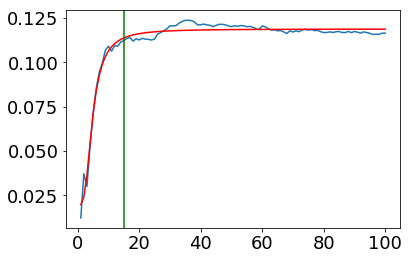

15
0
intact
3


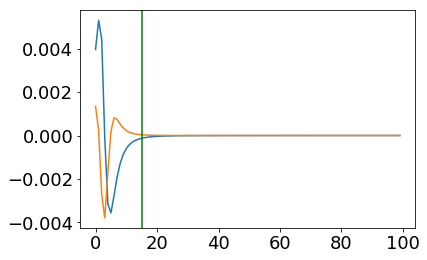

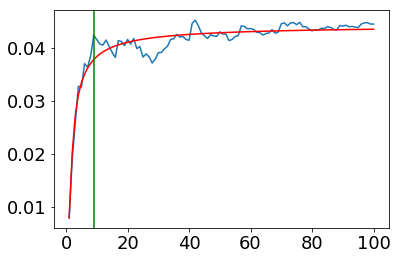

9
0
paragraph
3


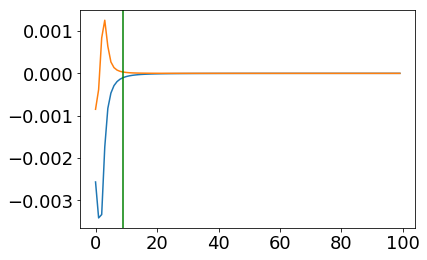

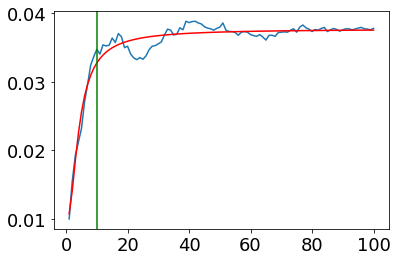

10
0
word
3


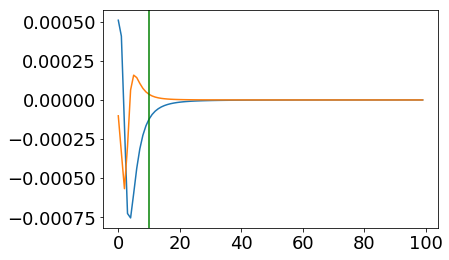

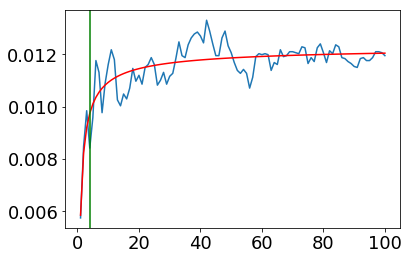

4
0
rest
3


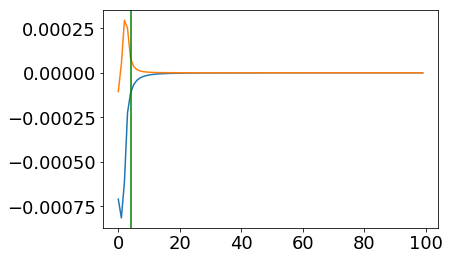

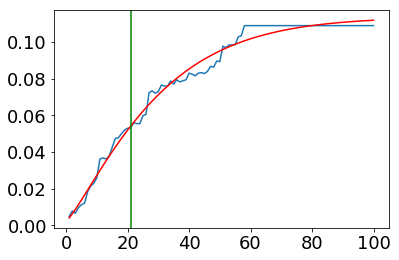

21
1
intact
3


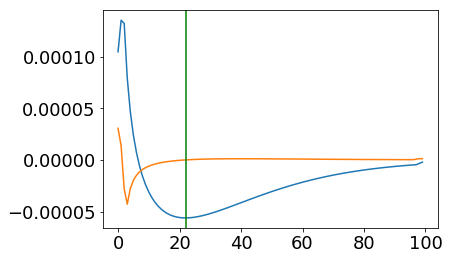

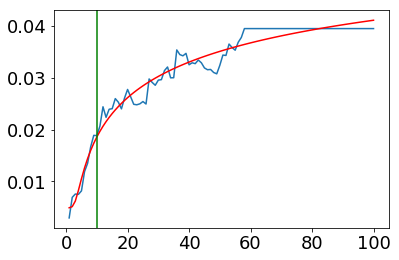

10
1
paragraph
3


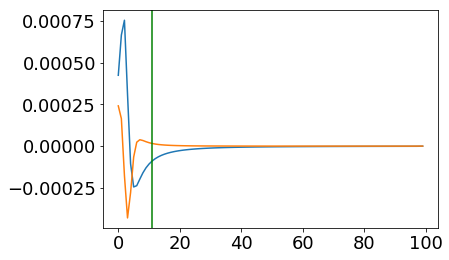

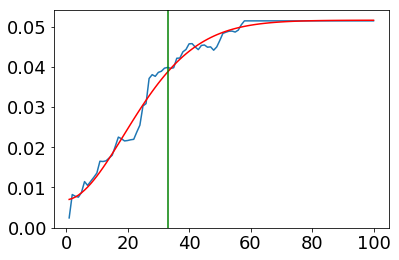

33
1
word
3


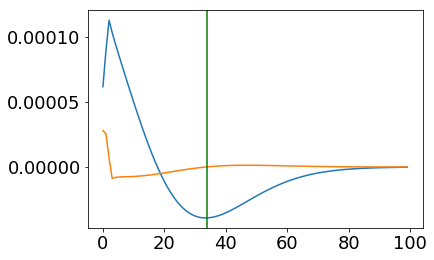

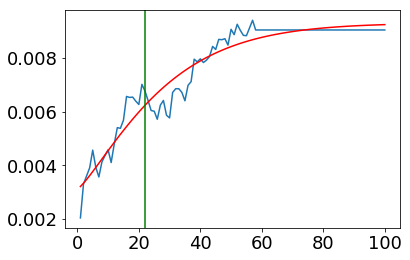

22
1
rest
3


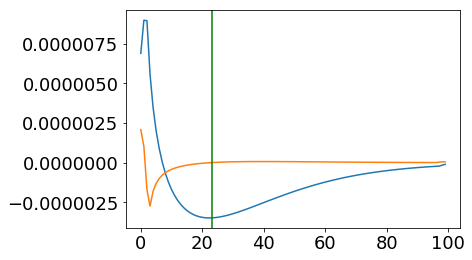

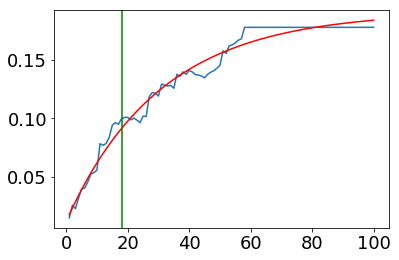

18
1
intact
1


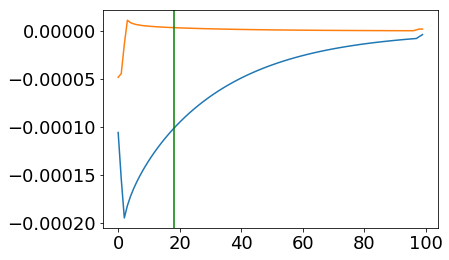

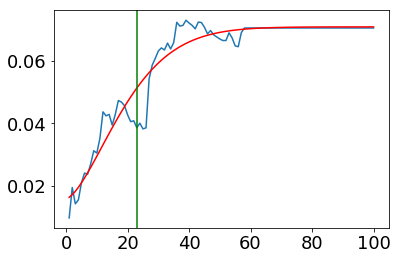

23
1
paragraph
1


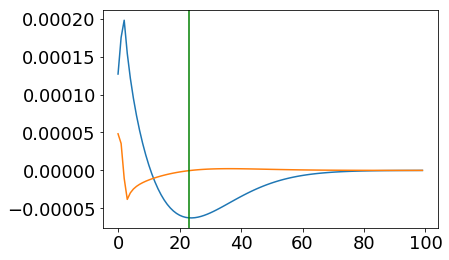

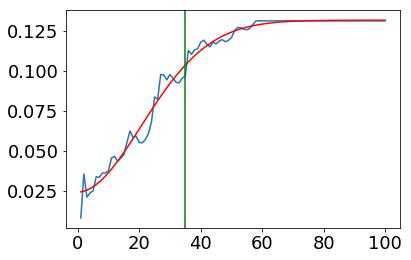

35
1
word
1


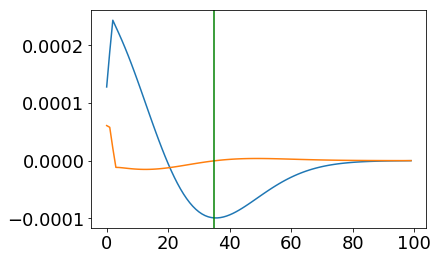

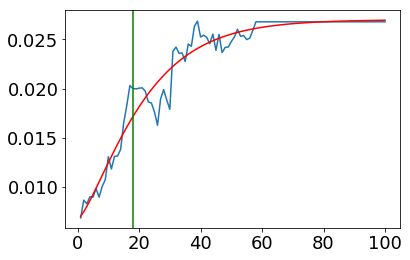

18
1
rest
1


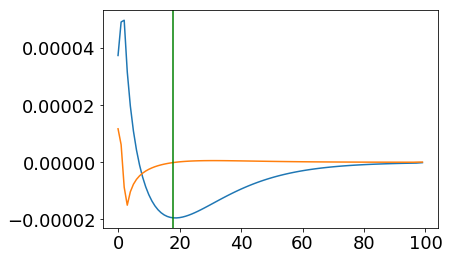

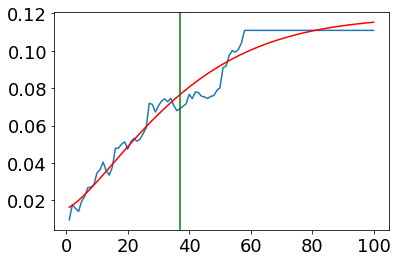

37
1
intact
2


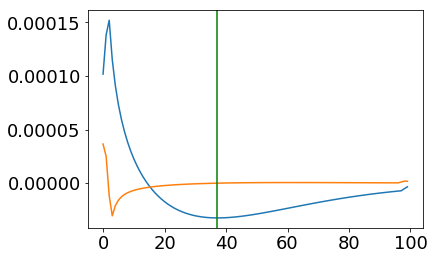

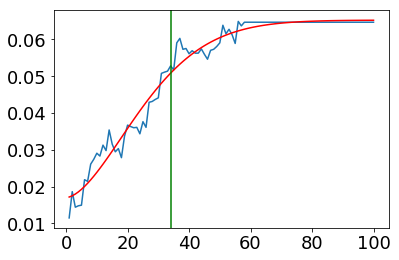

34
1
paragraph
2


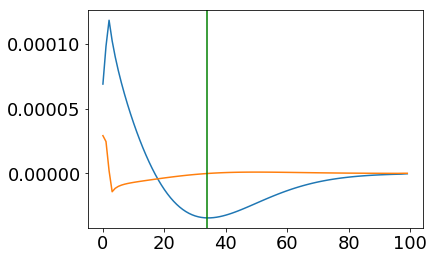

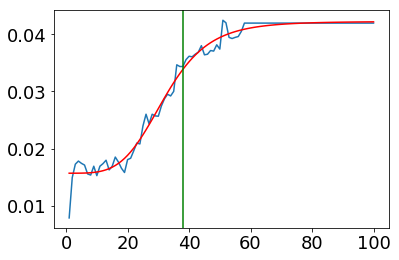

38
1
word
2


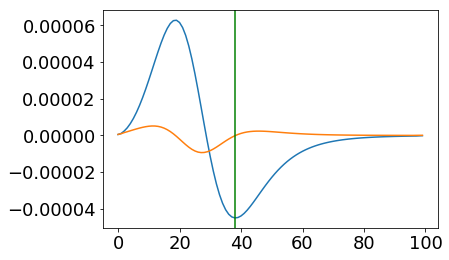

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


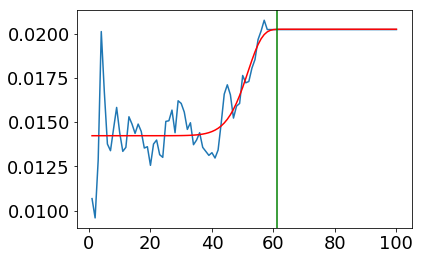

61
1
rest
2


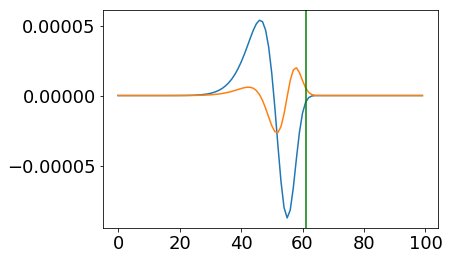

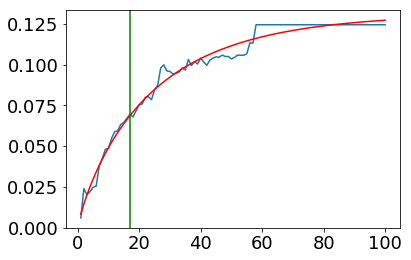

17
1
intact
3


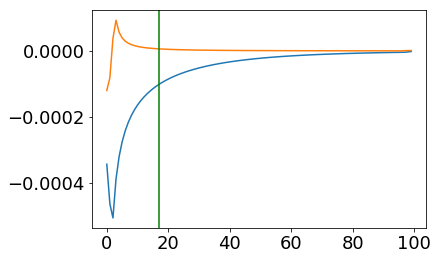

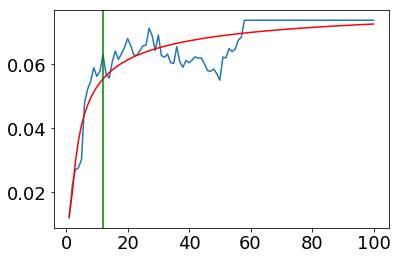

12
1
paragraph
3


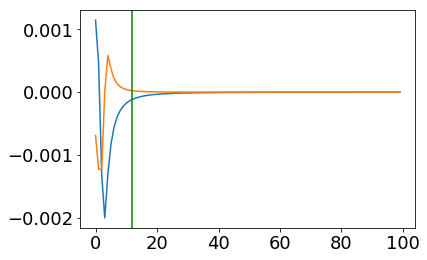

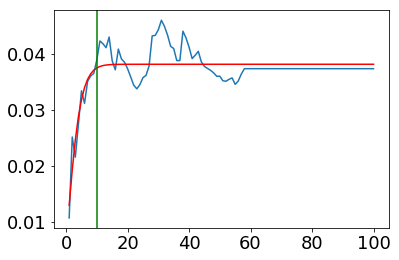

10
1
word
3


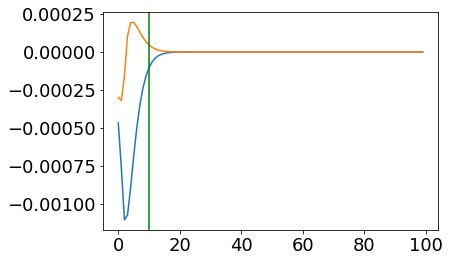

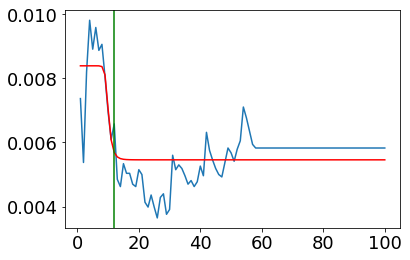

12
1
rest
3


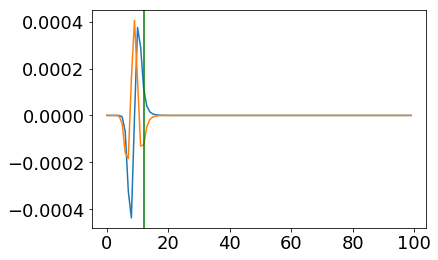

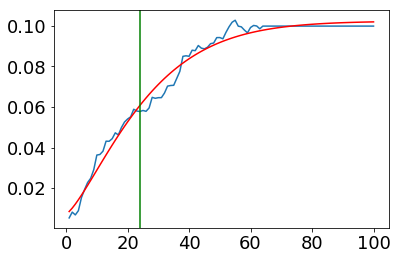

24
2
intact
3


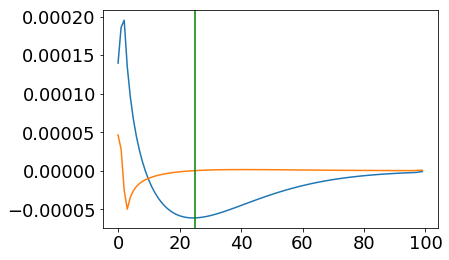

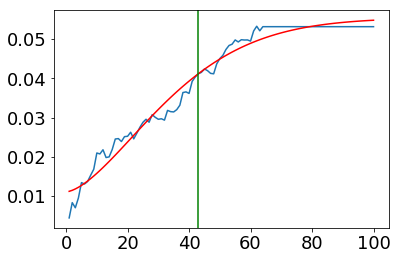

43
2
paragraph
3


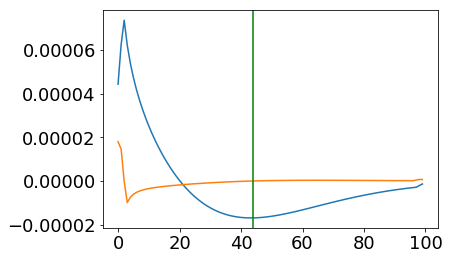

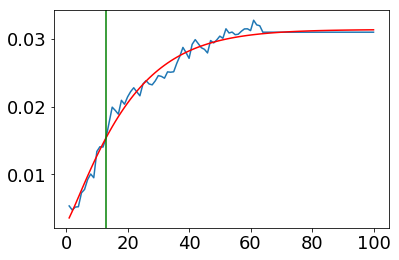

13
2
word
3


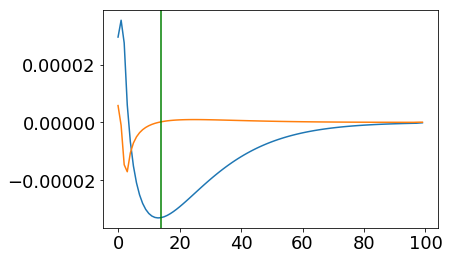

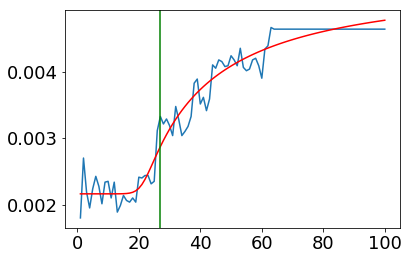

27
2
rest
3


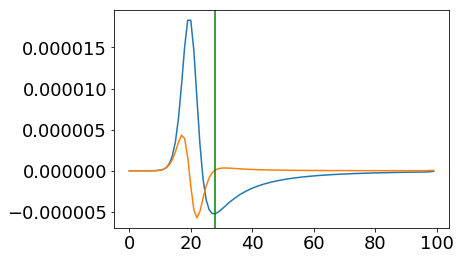

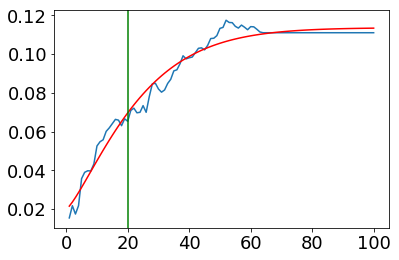

20
2
intact
1


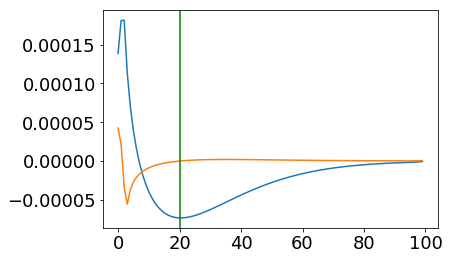

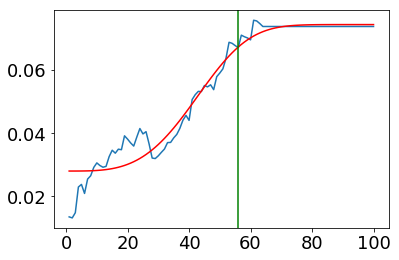

56
2
paragraph
1


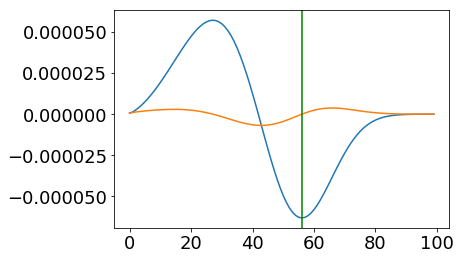

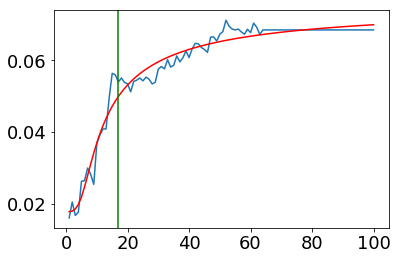

17
2
word
1


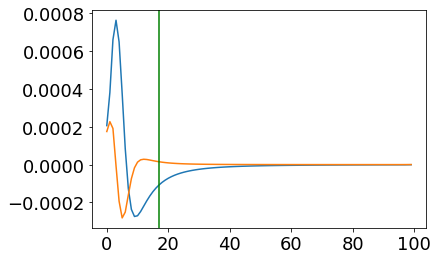

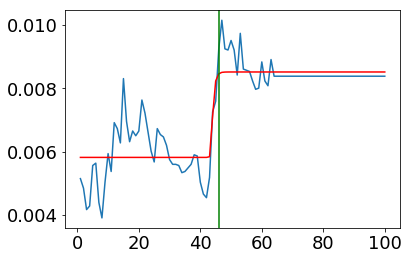

46
2
rest
1


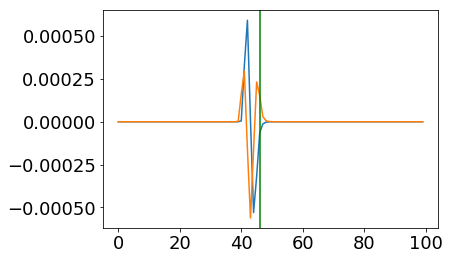

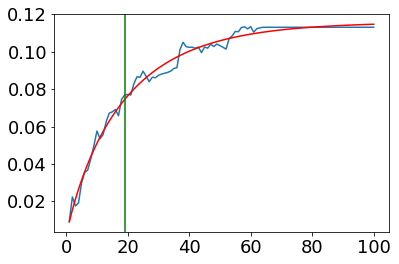

19
2
intact
2


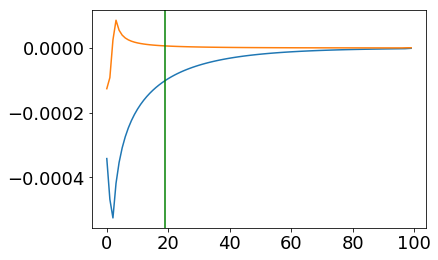

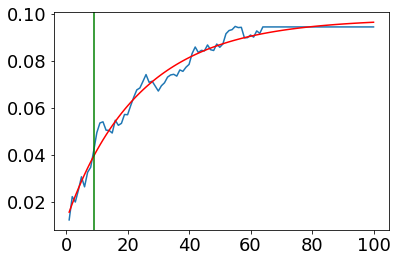

9
2
paragraph
2


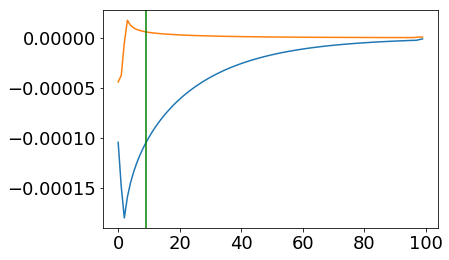

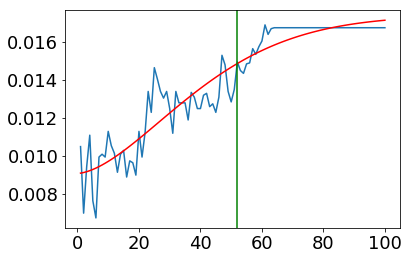

52
2
word
2


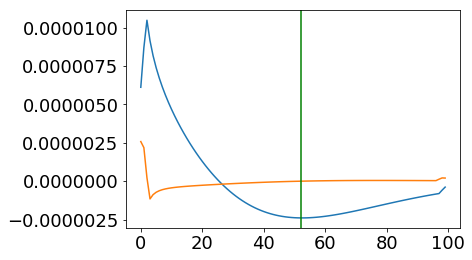

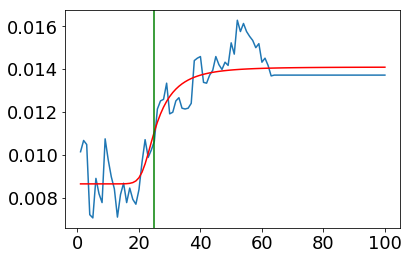

25
2
rest
2


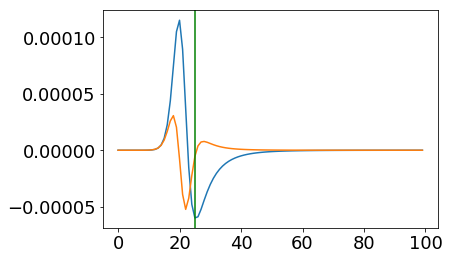

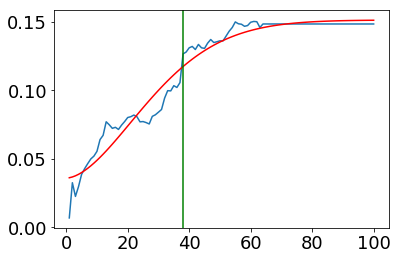

38
2
intact
3


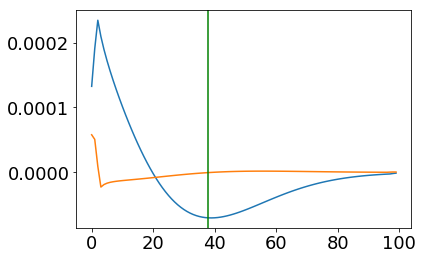

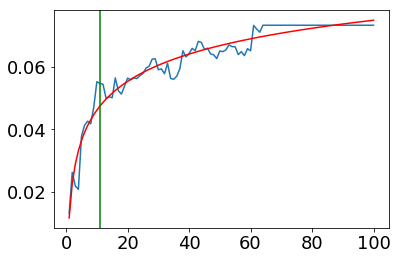

11
2
paragraph
3


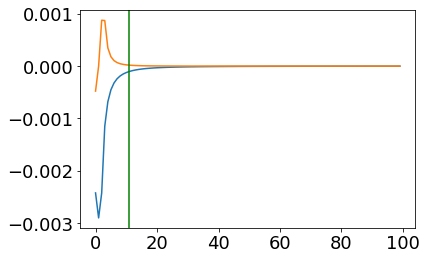

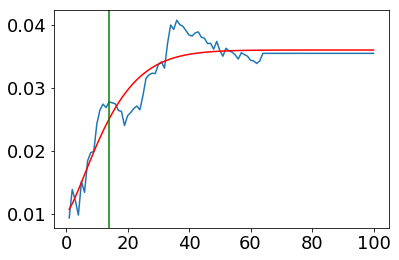

14
2
word
3


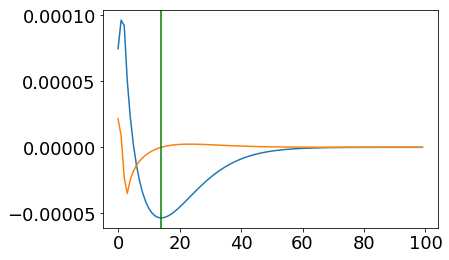

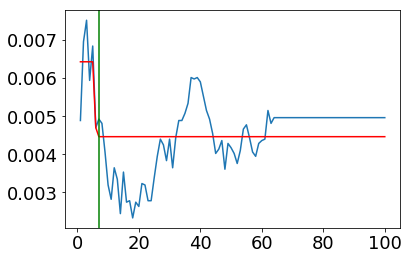

7
2
rest
3


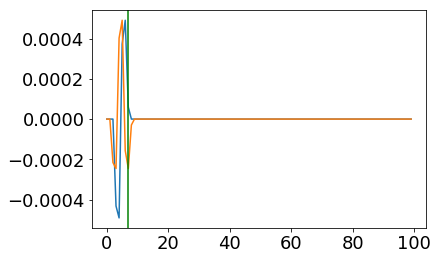

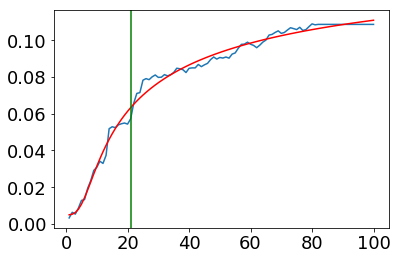

21
3
intact
3


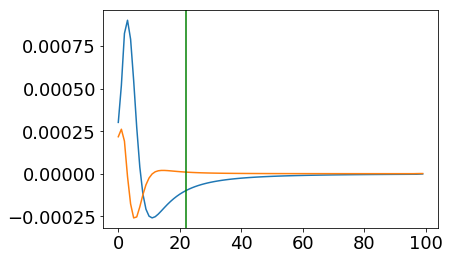

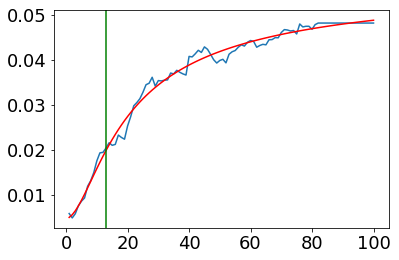

13
3
paragraph
3


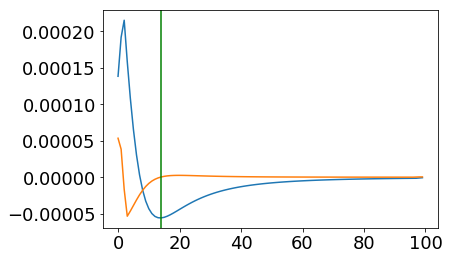

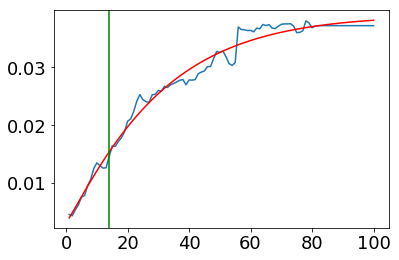

14
3
word
3


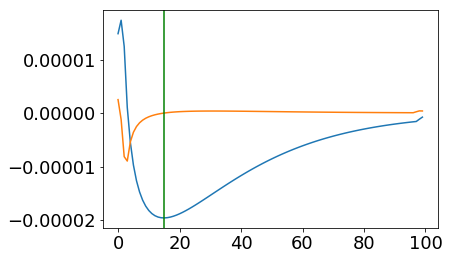

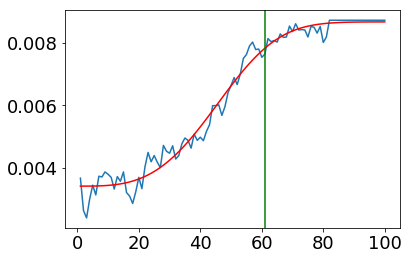

61
3
rest
3


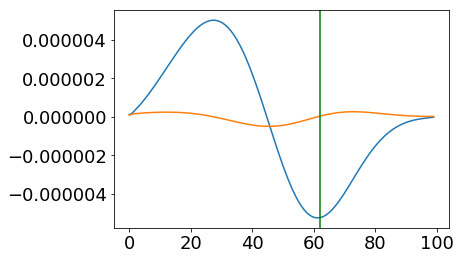

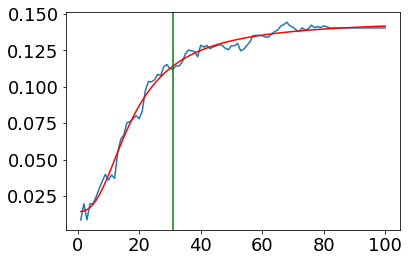

31
3
intact
1


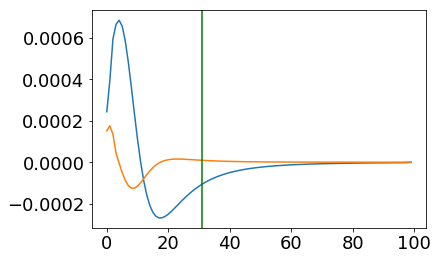

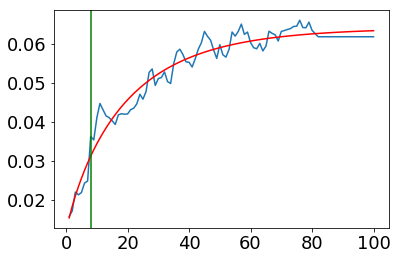

8
3
paragraph
1


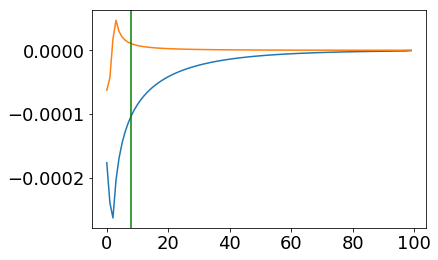

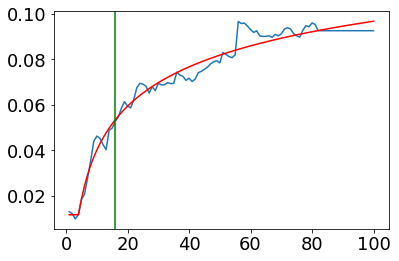

16
3
word
1


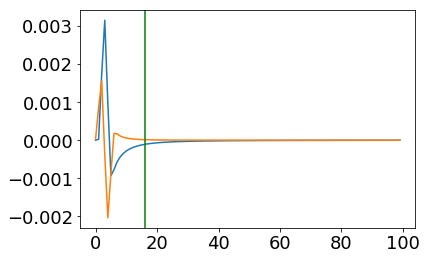

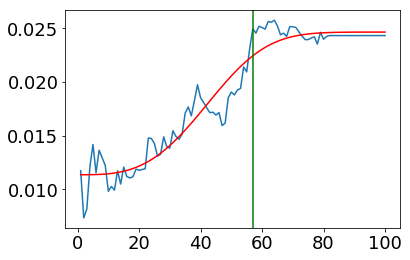

57
3
rest
1


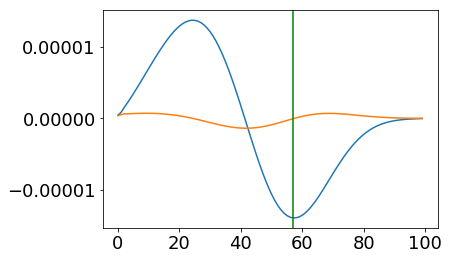

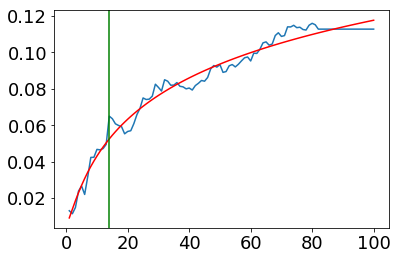

14
3
intact
2


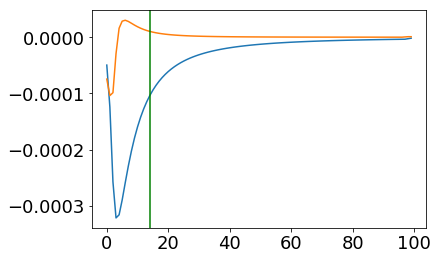

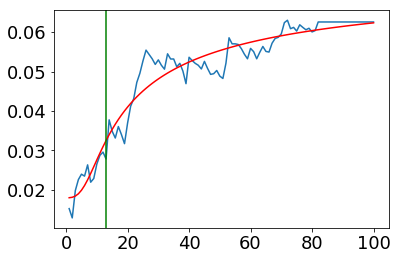

13
3
paragraph
2


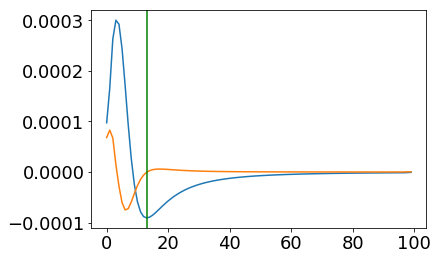

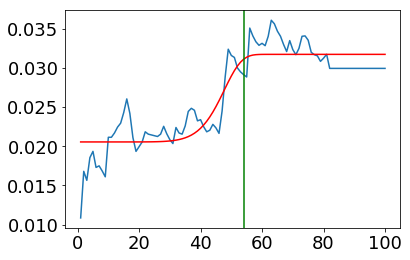

54
3
word
2


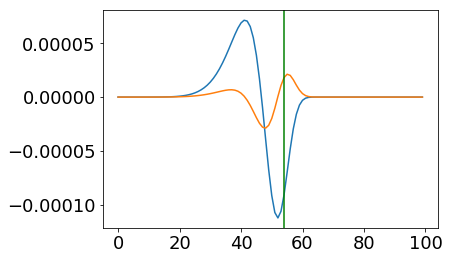

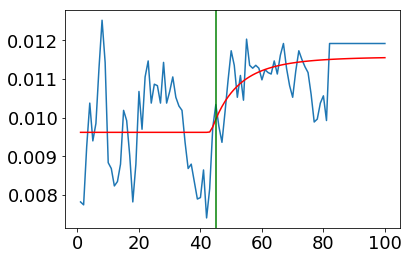

45
3
rest
2


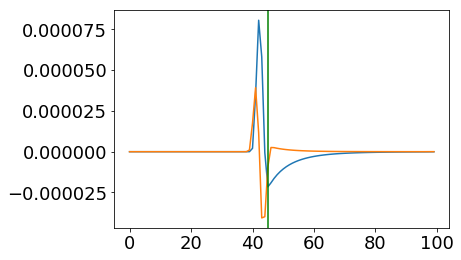

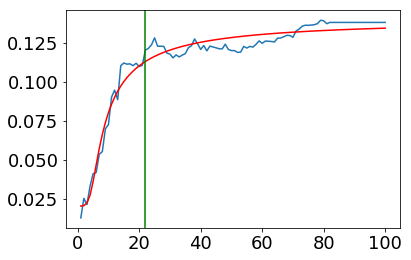

22
3
intact
3


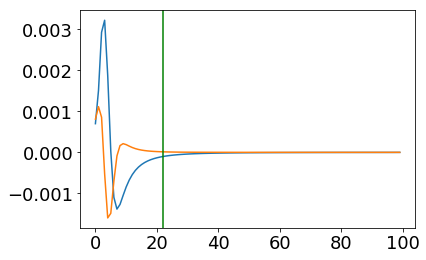

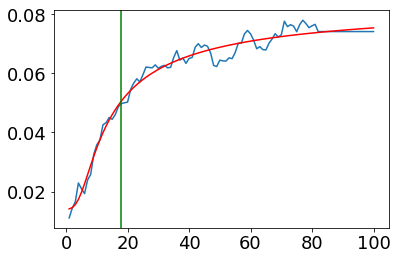

18
3
paragraph
3


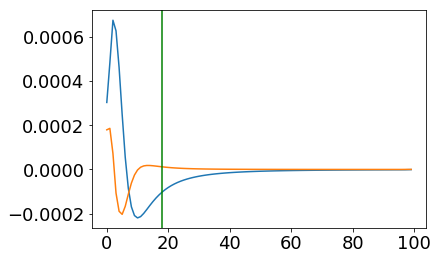

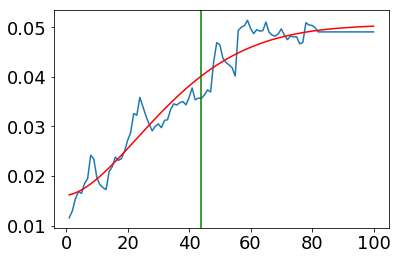

44
3
word
3


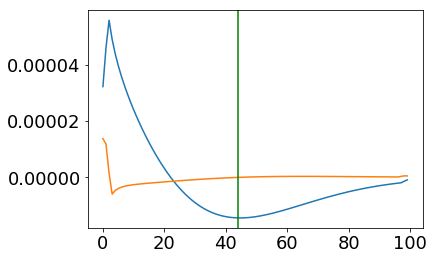

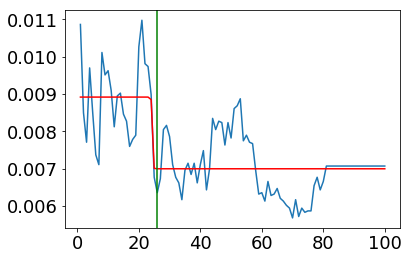

26
3
rest
3


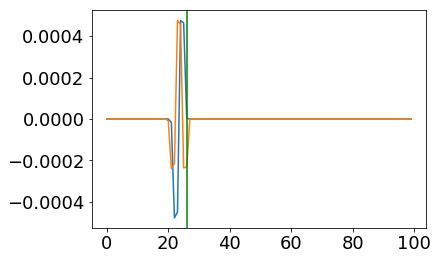

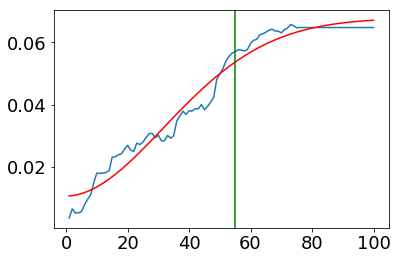

55
4
intact
3


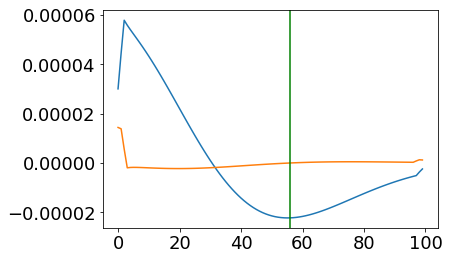

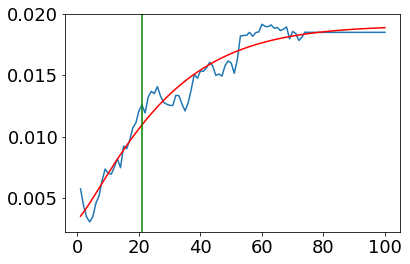

21
4
paragraph
3


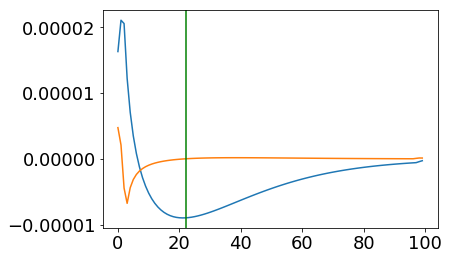

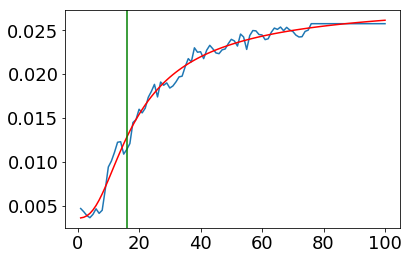

16
4
word
3


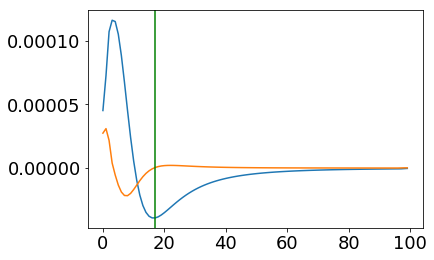

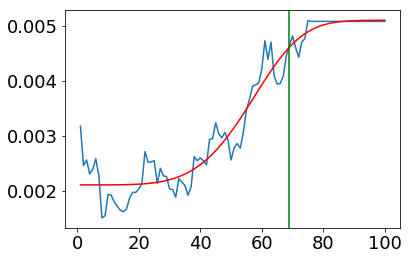

69
4
rest
3


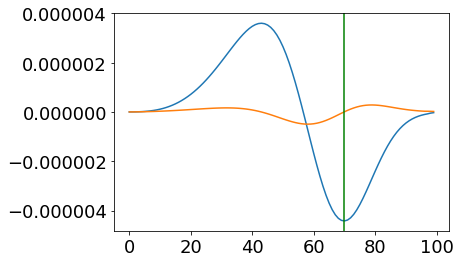

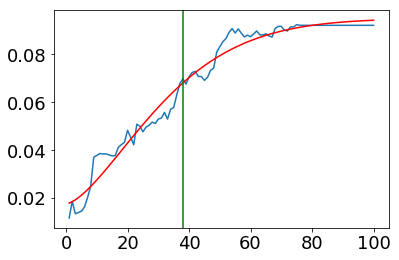

38
4
intact
1


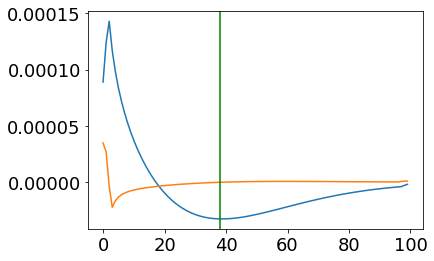

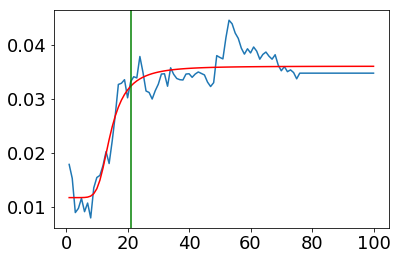

21
4
paragraph
1


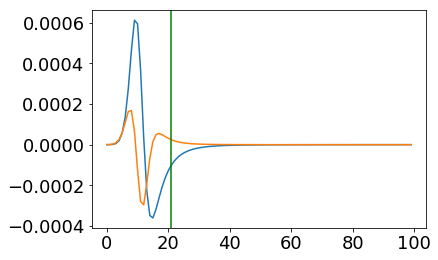

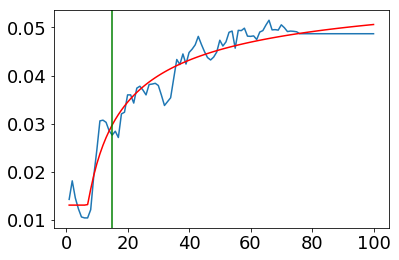

15
4
word
1


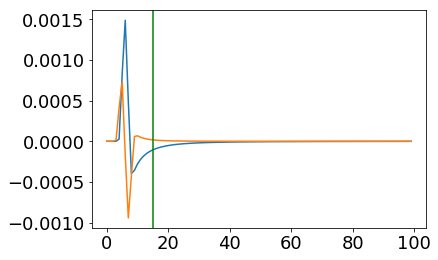

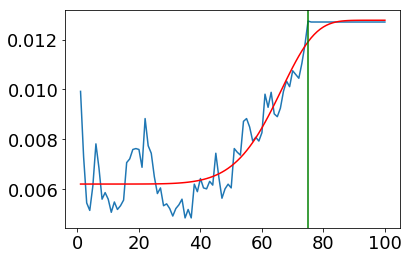

75
4
rest
1


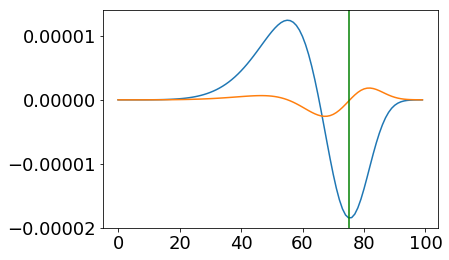

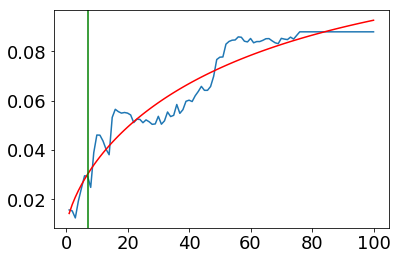

7
4
intact
2


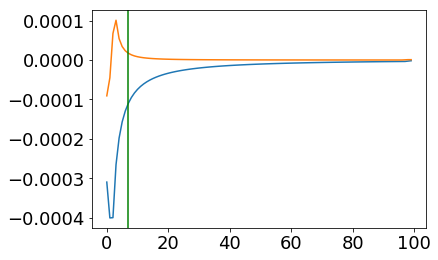

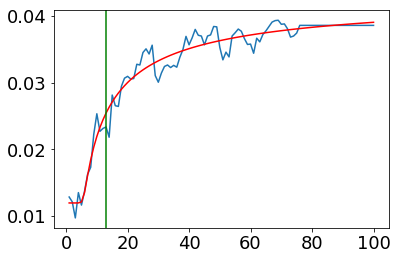

13
4
paragraph
2


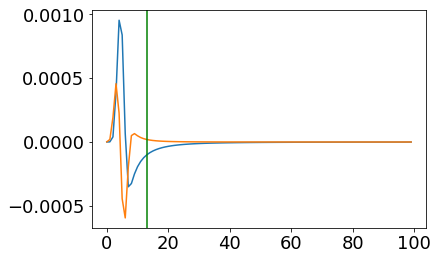

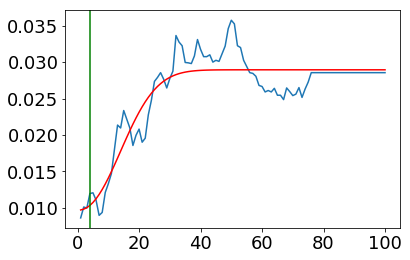

4
4
word
2


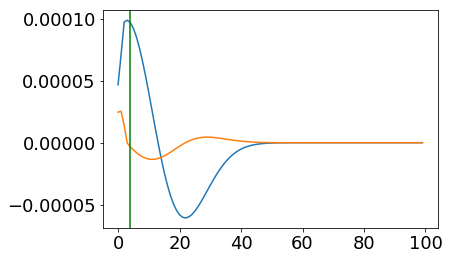

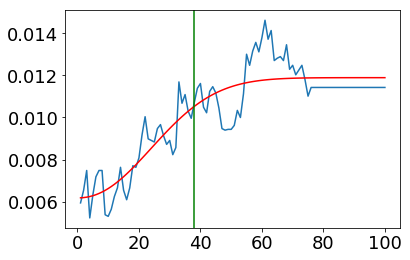

38
4
rest
2


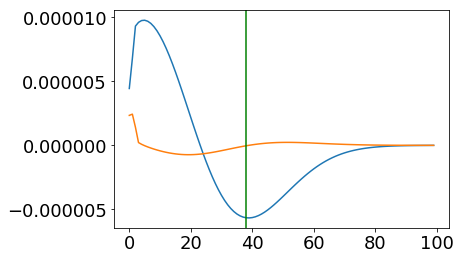

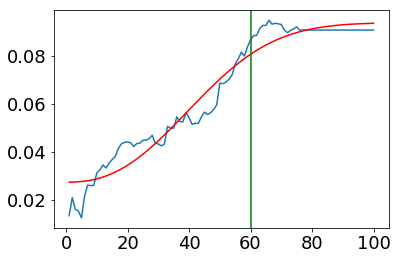

60
4
intact
3


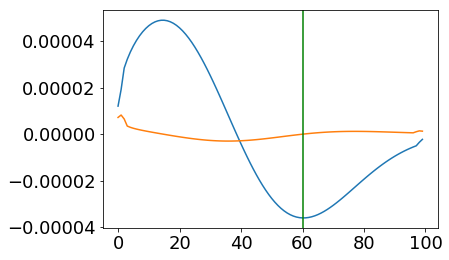

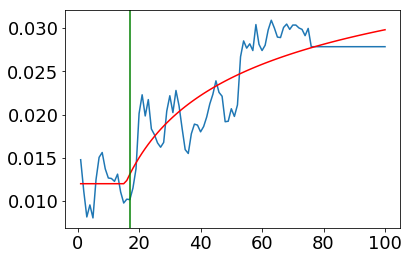

17
4
paragraph
3


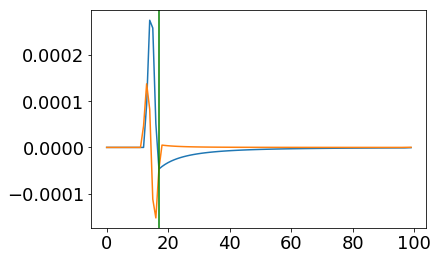

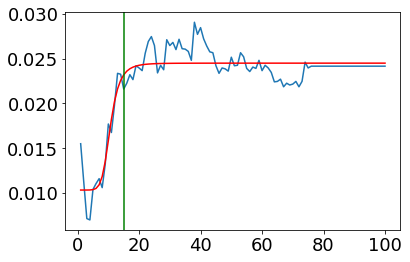

15
4
word
3


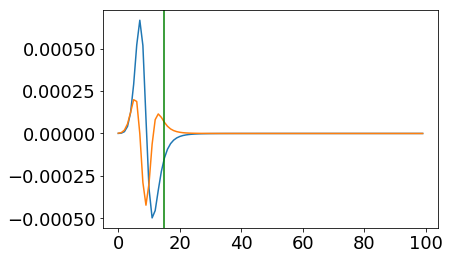

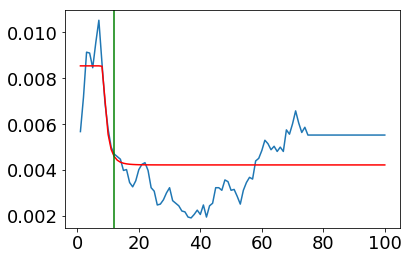

12
4
rest
3


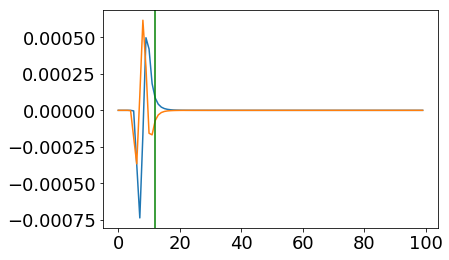

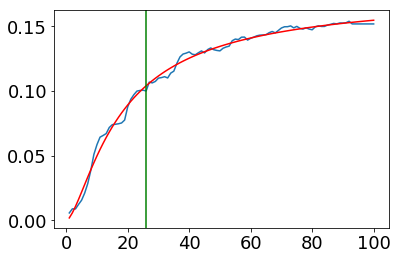

26
5
intact
3


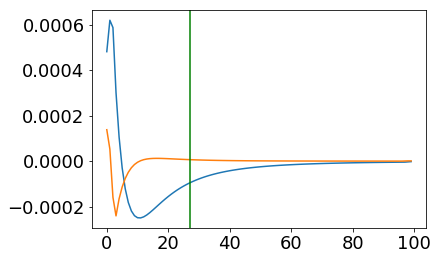

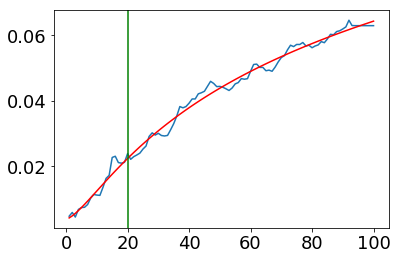

20
5
paragraph
3


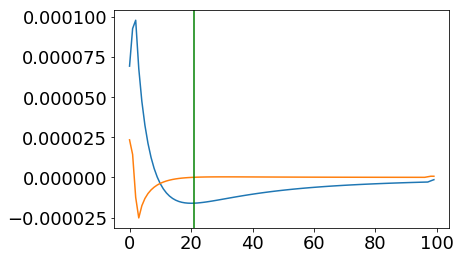

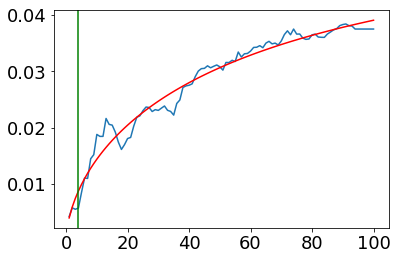

4
5
word
3


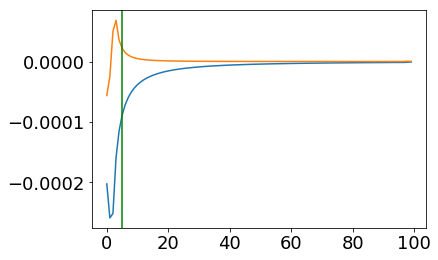

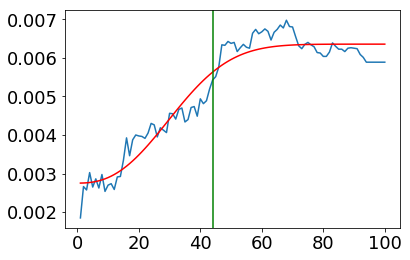

44
5
rest
3


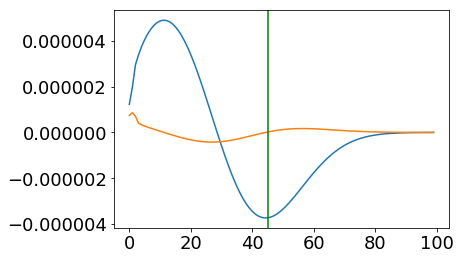

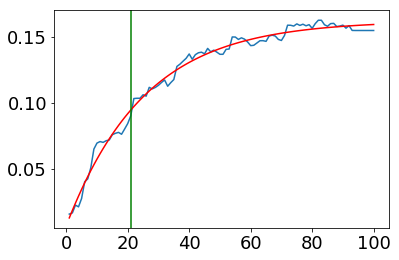

21
5
intact
1


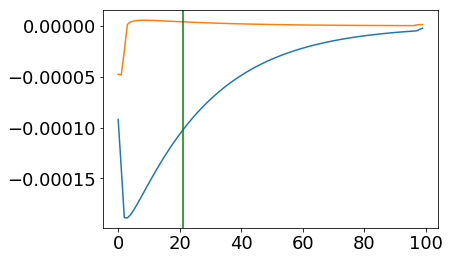

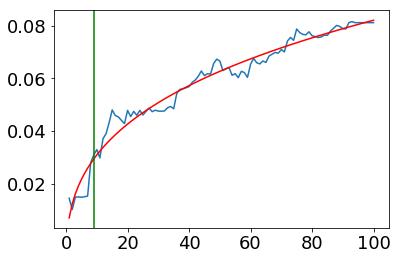

9
5
paragraph
1


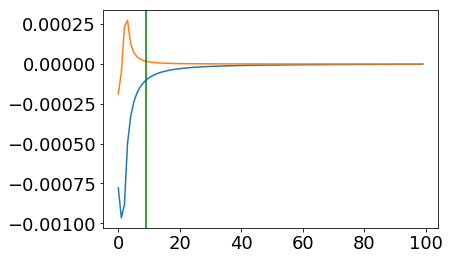

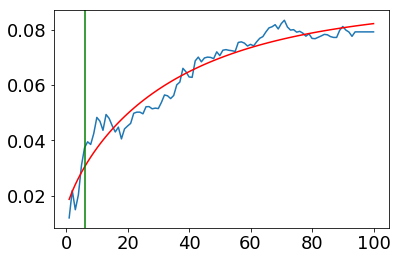

6
5
word
1


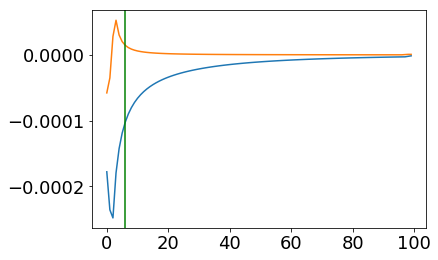

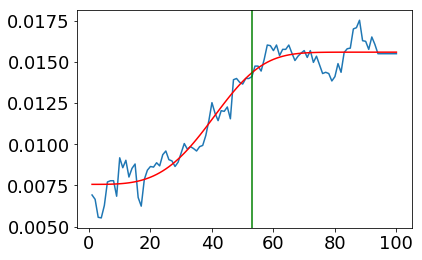

53
5
rest
1


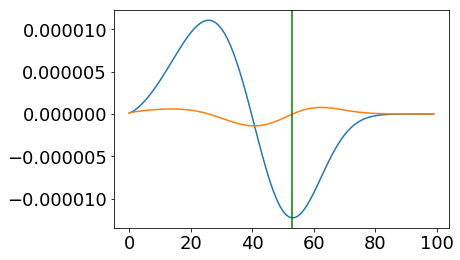

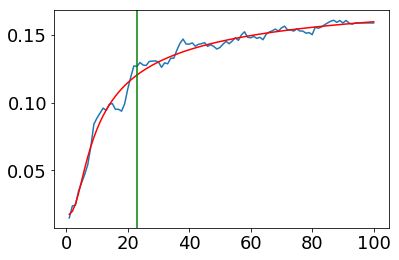

23
5
intact
2


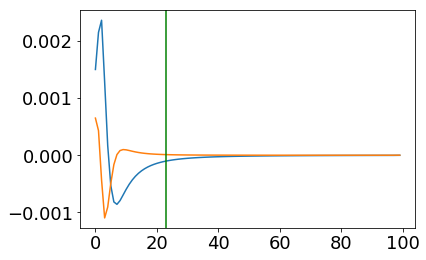

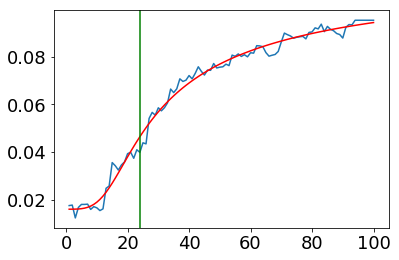

24
5
paragraph
2


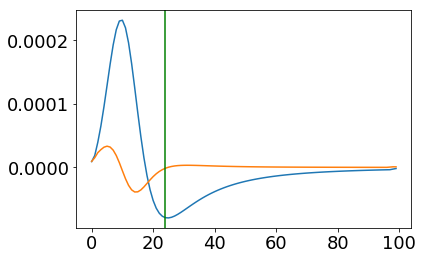

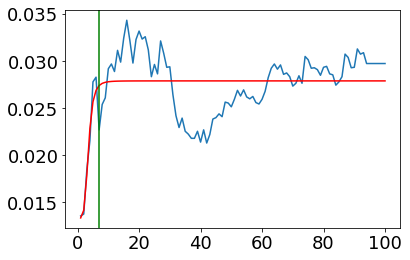

7
5
word
2


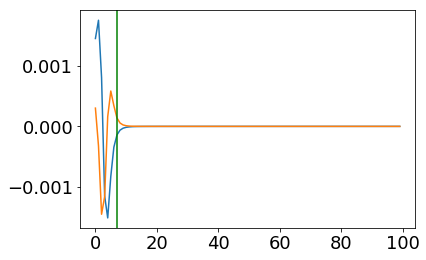

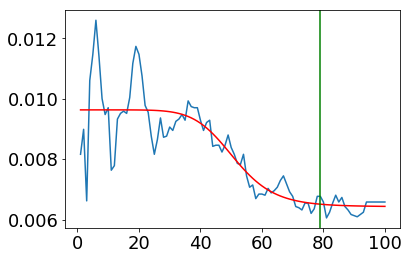

79
5
rest
2


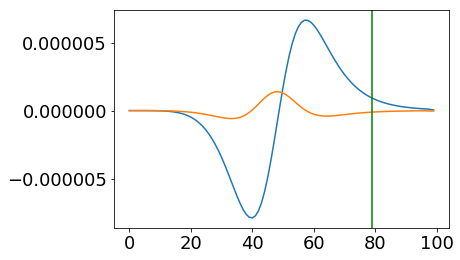

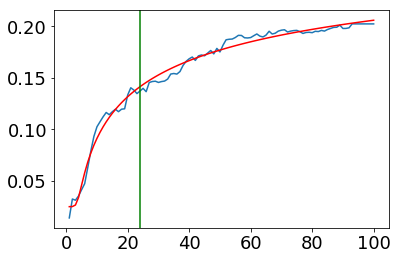

24
5
intact
3


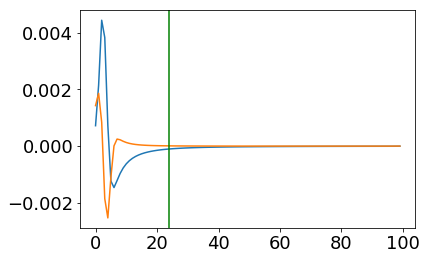

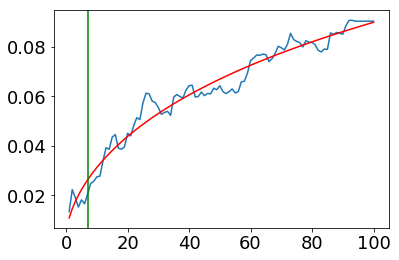

7
5
paragraph
3


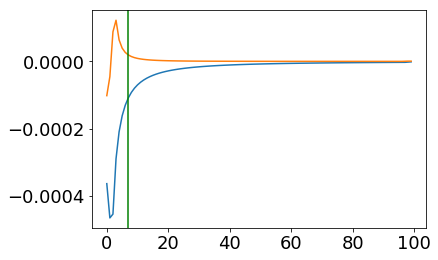

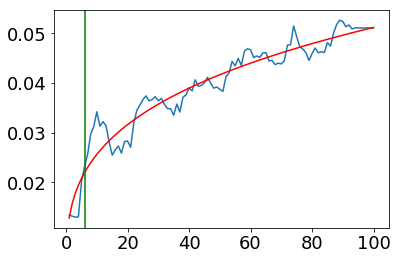

6
5
word
3


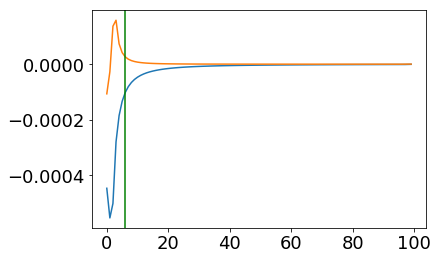

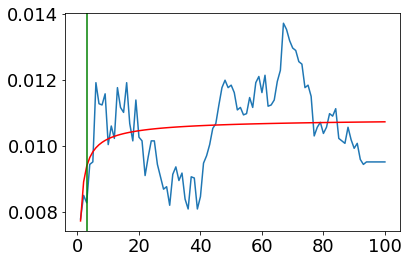

3
5
rest
3


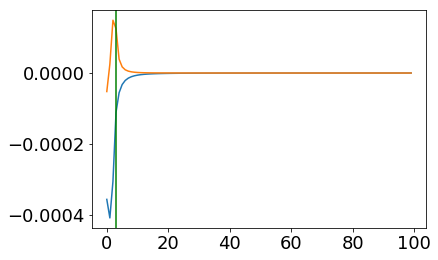

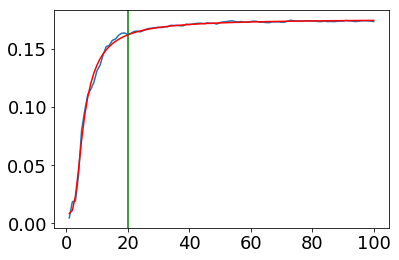

20
6
intact
3


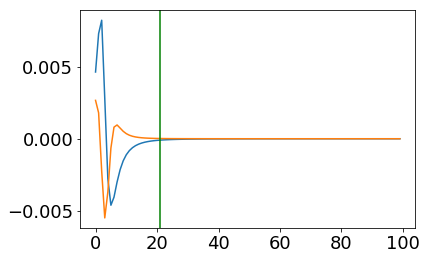

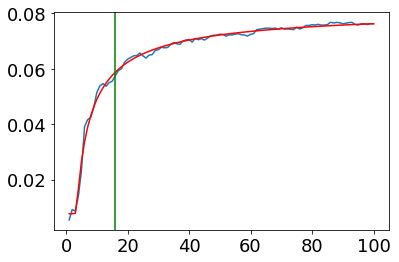

16
6
paragraph
3


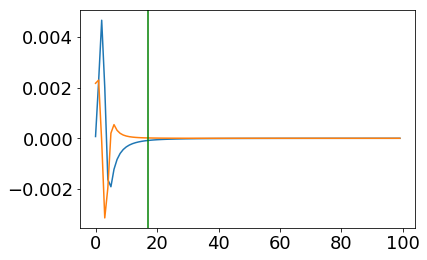

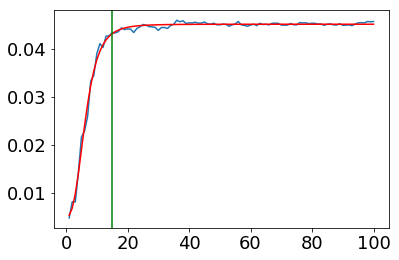

15
6
word
3


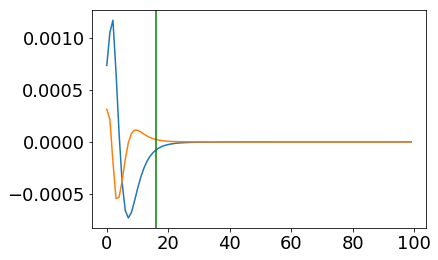

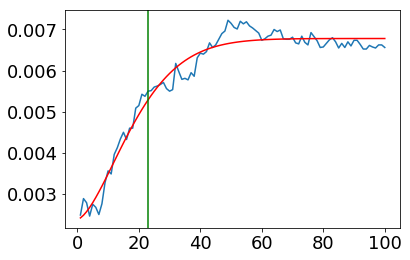

23
6
rest
3


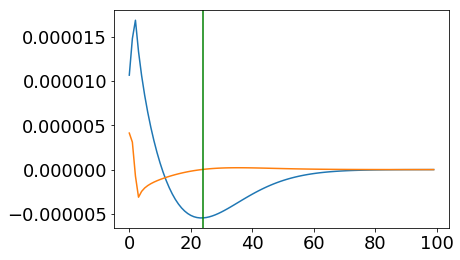

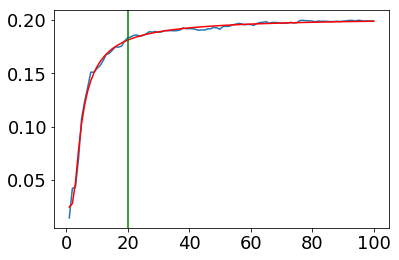

20
6
intact
1


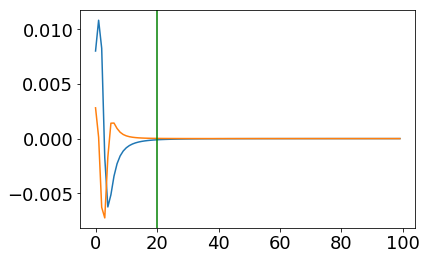

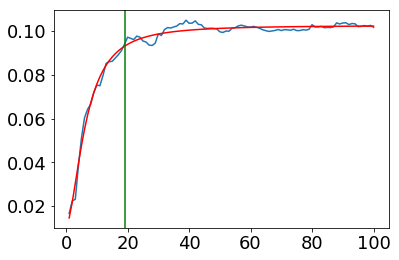

19
6
paragraph
1


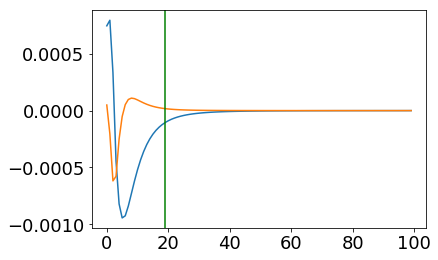

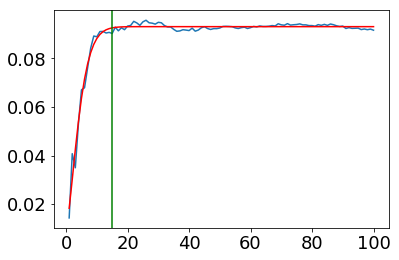

15
6
word
1


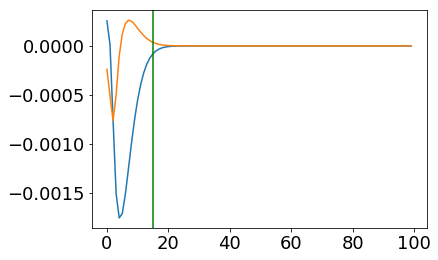

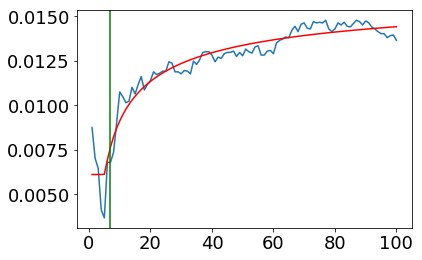

7
6
rest
1


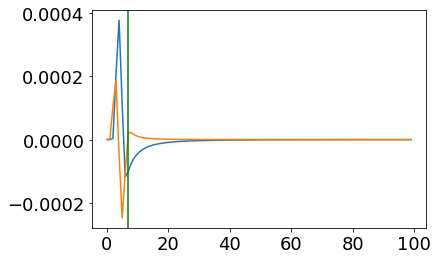

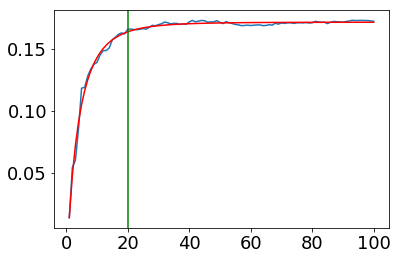

20
6
intact
2


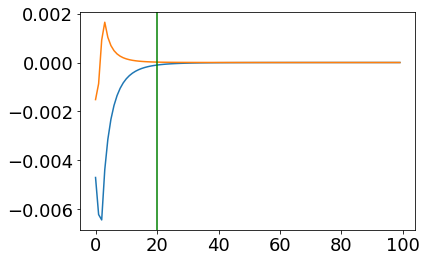

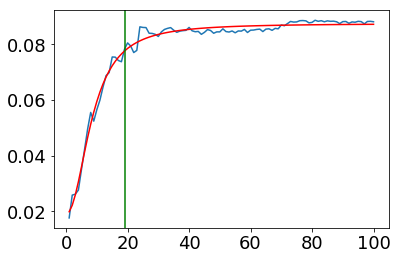

19
6
paragraph
2


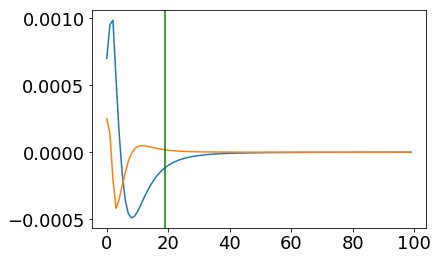

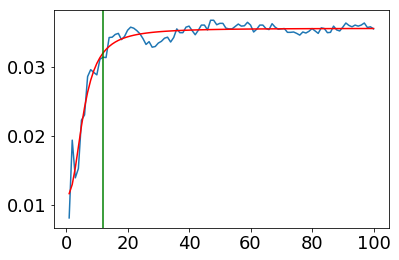

12
6
word
2


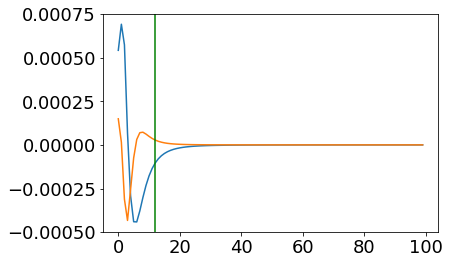

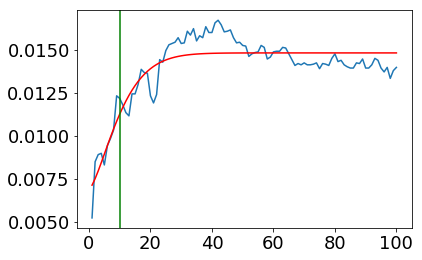

10
6
rest
2


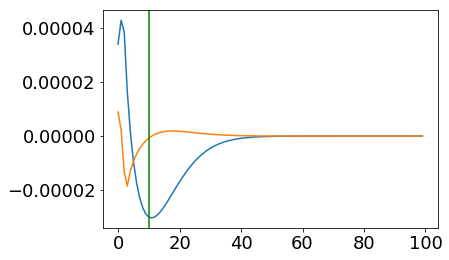

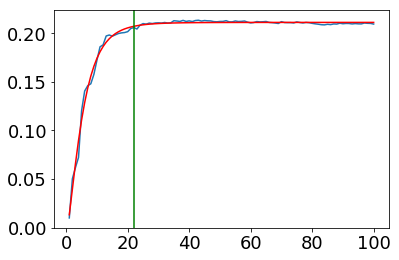

22
6
intact
3


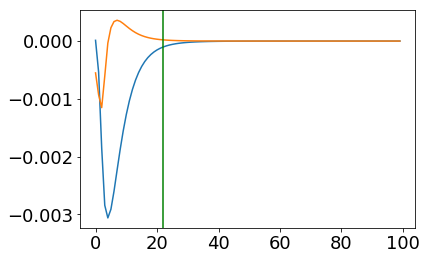

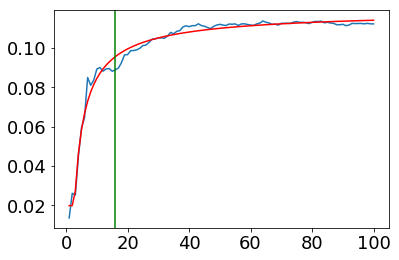

16
6
paragraph
3


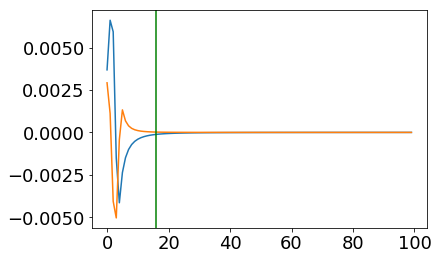

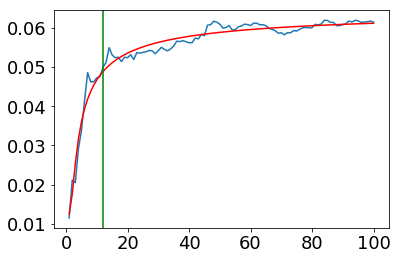

12
6
word
3


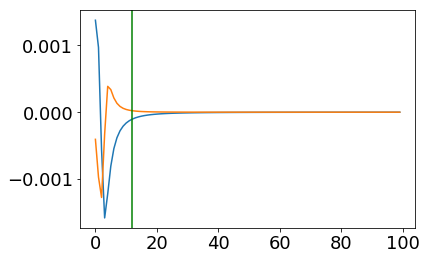

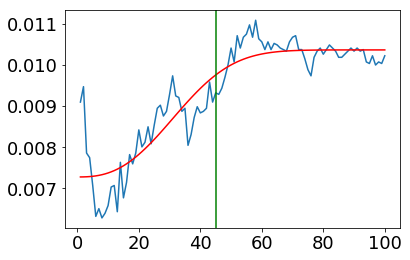

45
6
rest
3


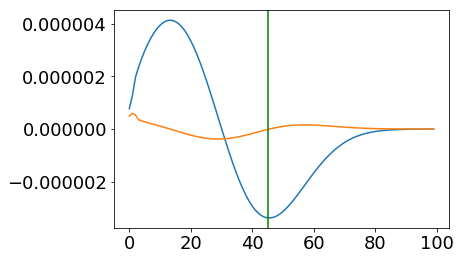

In [976]:

maxs_ns = np.zeros((7, 4, 4))
hills_ns = np.zeros((7, 4, 4))

hill_all = np.zeros((4, 4))
maxs_all = np.zeros((4, 4))

for n in np.arange(len(network_list)):

    resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network/PCA/ndims_100'

    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

            
    conditions = ['intact', 'paragraph', 'word', 'rest']

    hill_all = np.zeros((4, 4))
    maxs_all = np.zeros((4, 4))


    for e, c in enumerate(conditions):


        ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
        xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

        popt, pcov = curve_fit(func, xdata, ydata, maxfev=10000)
        

        f = scipy.interpolate.interp1d(xdata, func(xdata, *popt), 'cubic')
        y = f(xdata)

        hill_all[e, 0] = maxima_2(y)

        maxs_all[e, 0] = func(maxima_2(y), *popt)
        
        plt.plot(xdata, ydata)
        plt.plot(xdata, func(xdata, *popt), 'r-')
        plt.axvline(x=maxima_2(y), color='g', linestyle='-')
        plt.show()
        
        print(maxima_2(y))
        print(n)
        print(c)
        print(i)
        plt.plot(n_derivative(y, 2))
        plt.plot(n_derivative(y, 3))
        plt.axvline(x=xdata[maxima_2(y)].min(), color='g', linestyle='-')
        plt.show()
        
    resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100'
    
    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)

    conditions = ['intact', 'paragraph', 'word', 'rest']

    for i in np.arange(1, 4):

        full_data_temp = full_data[full_data['third']==i-1]

        for e, c in enumerate(conditions):


            ydata = full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
            xdata = np.array(full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().index)

            popt, pcov = curve_fit(func, xdata, ydata, maxfev=1000000)
    
            f = scipy.interpolate.interp1d(xdata, func(xdata, *popt), 'cubic')
            y = f(xdata)

            hill_all[e, i] = maxima_2(y)

            maxs_all[e, i] = func(maxima_2(y), *popt)

            plt.plot(xdata, ydata)
            plt.plot(xdata, func(xdata, *popt), 'r-')
            plt.axvline(x=maxima_2(y), color='g', linestyle='-')
            plt.show()
            
            print(maxima_2(y))
            print(n)
            print(c)
            print(i)
            plt.plot(n_derivative(y, 2))
            plt.plot(n_derivative(y, 3))

            plt.axvline(x=maxima_2(y), color='g', linestyle='-')
            plt.show()
            
    hills_ns[n, :, :] = hill_all
    
    maxs_ns[n, :, :] = maxs_all

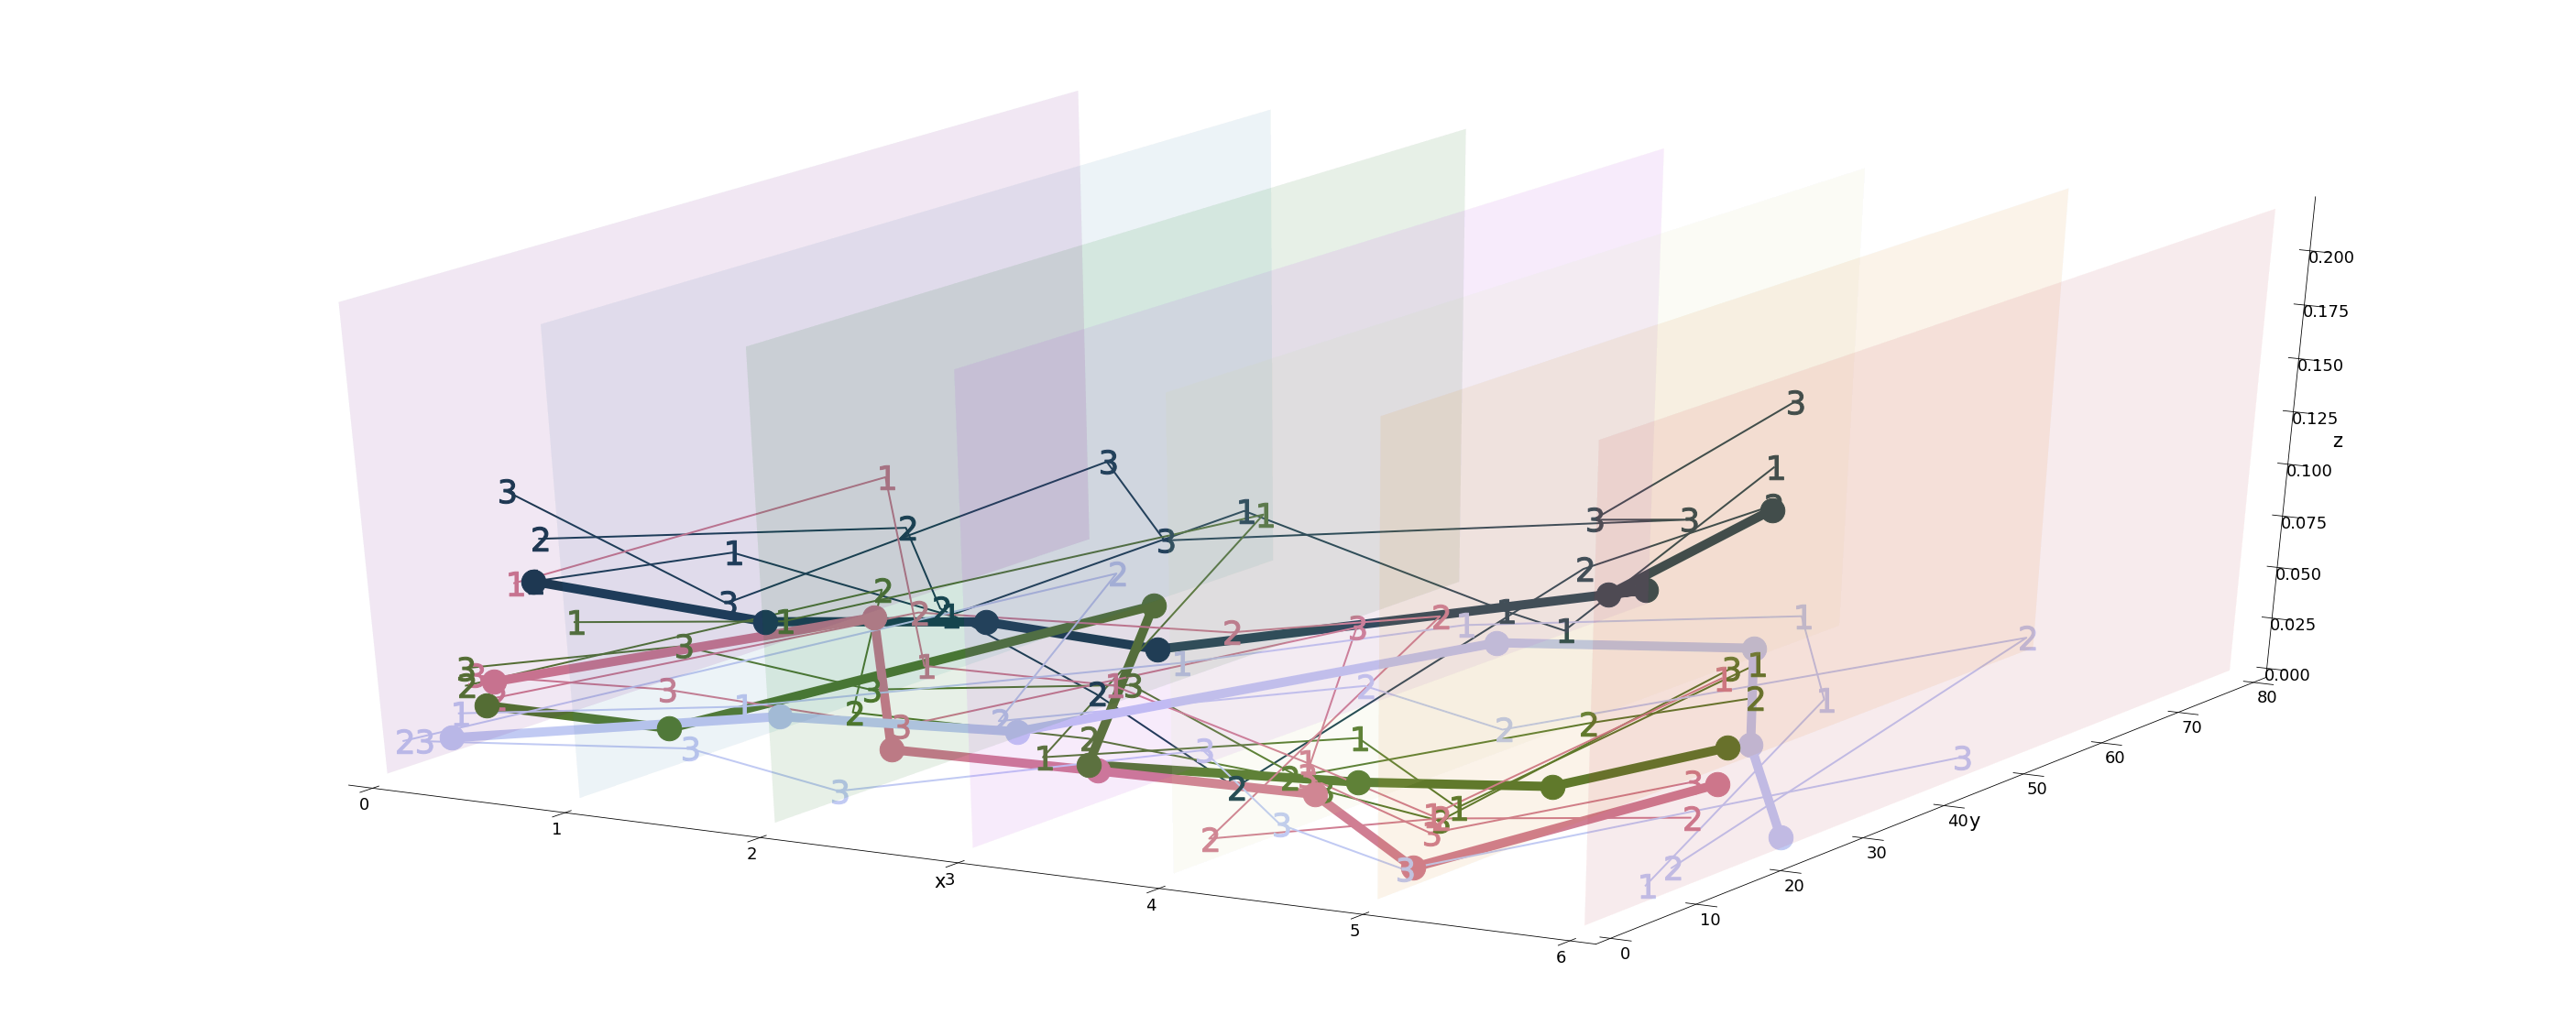

In [980]:
markers=['o', '$1$', '$2$','$3$']

plt.figure('SPLTV',figsize=(50,20))

ax=plt.subplot(projection='3d')

ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.set_xlim(0,6)
ax.set_ylim(0,80)
ax.set_zlim(0,.22)

markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)

for n in np.arange(len(network_list)):
#for n in [1]:
    for e, c in enumerate(conditions):
        # 1. create vertices from points
        verts = [[(n, 80, 0), (n, 80, 0.22), (n, 0, 0.22), (n, 0, 0),]]
        #verts = [list(zip(hills_ns[n, e], [n]*4, maxs_ns[n, e]))]
        # 2. create 3d polygons and specify parameters
        srf = Poly3DCollection(verts, alpha=.025, facecolor=color_stacked[n])
        # 3. add polygon to the figure (current axes)
        plt.gca().add_collection3d(srf)
        

#ax.plot([1,2,3,4,5,6], hills_ns[n, e, 1], maxs_ns[n, e, 1], color=colors[e])

for e, c in enumerate(conditions):
    for i in np.arange(4):

    #ax.plot([n]*3, hills_ns[n, e, 1:], maxs_ns[n, e, 1:], color=colors[e])
        if i ==0:
            ax.plot([0,1,2,3,4,5,6], hills_ns[:, e, i], maxs_ns[:, e, i], 
                    color=colors[e], linewidth=10)

        else:
            ax.plot([0,1,2,3,4,5,6], hills_ns[:, e, i], maxs_ns[:, e, i], 
                    color=colors[e], linewidth=2)
for n in np.arange(len(network_list)):
#for n in [1]:
    for e, c in enumerate(conditions):
        
        #ax.plot([n]*3, hills_ns[n, e, 1:], maxs_ns[n, e, 1:], color=colors[e])
        #ax.plot([0,1,2,3,4,5,6], hills_ns[n, e, 1], maxs_ns[n, e, 1], color=colors[e])
        for i in np.arange(4):
            #ax.plot(n,hills_ns[n, e, i], maxs_ns[n, e, i],'x-')
            
            ax.scatter(n, hills_ns[n, e, i], maxs_ns[n, e, i], 
                        marker=markers[i], s=700, color=colors[e])


        
# for n in np.arange(len(network_list)):
# #for n in [6]:
#     for e, c in enumerate(conditions):
#         # 1. create vertices from points
#         #verts = [[(n, 0.42, 0), (n, .42, 0.22), (n, 0, 0.22), (n, 0, 0),]]
#         verts = [list(zip([n]*4, hills_ns[n, e], maxs_ns[n, e]))]
#         # 2. create 3d polygons and specify parameters
#         srf = Poly3DCollection(verts, alpha=.2, facecolor=color_stacked[n])
#         # 3. add polygon to the figure (current axes)
#         plt.gca().add_collection3d(srf)

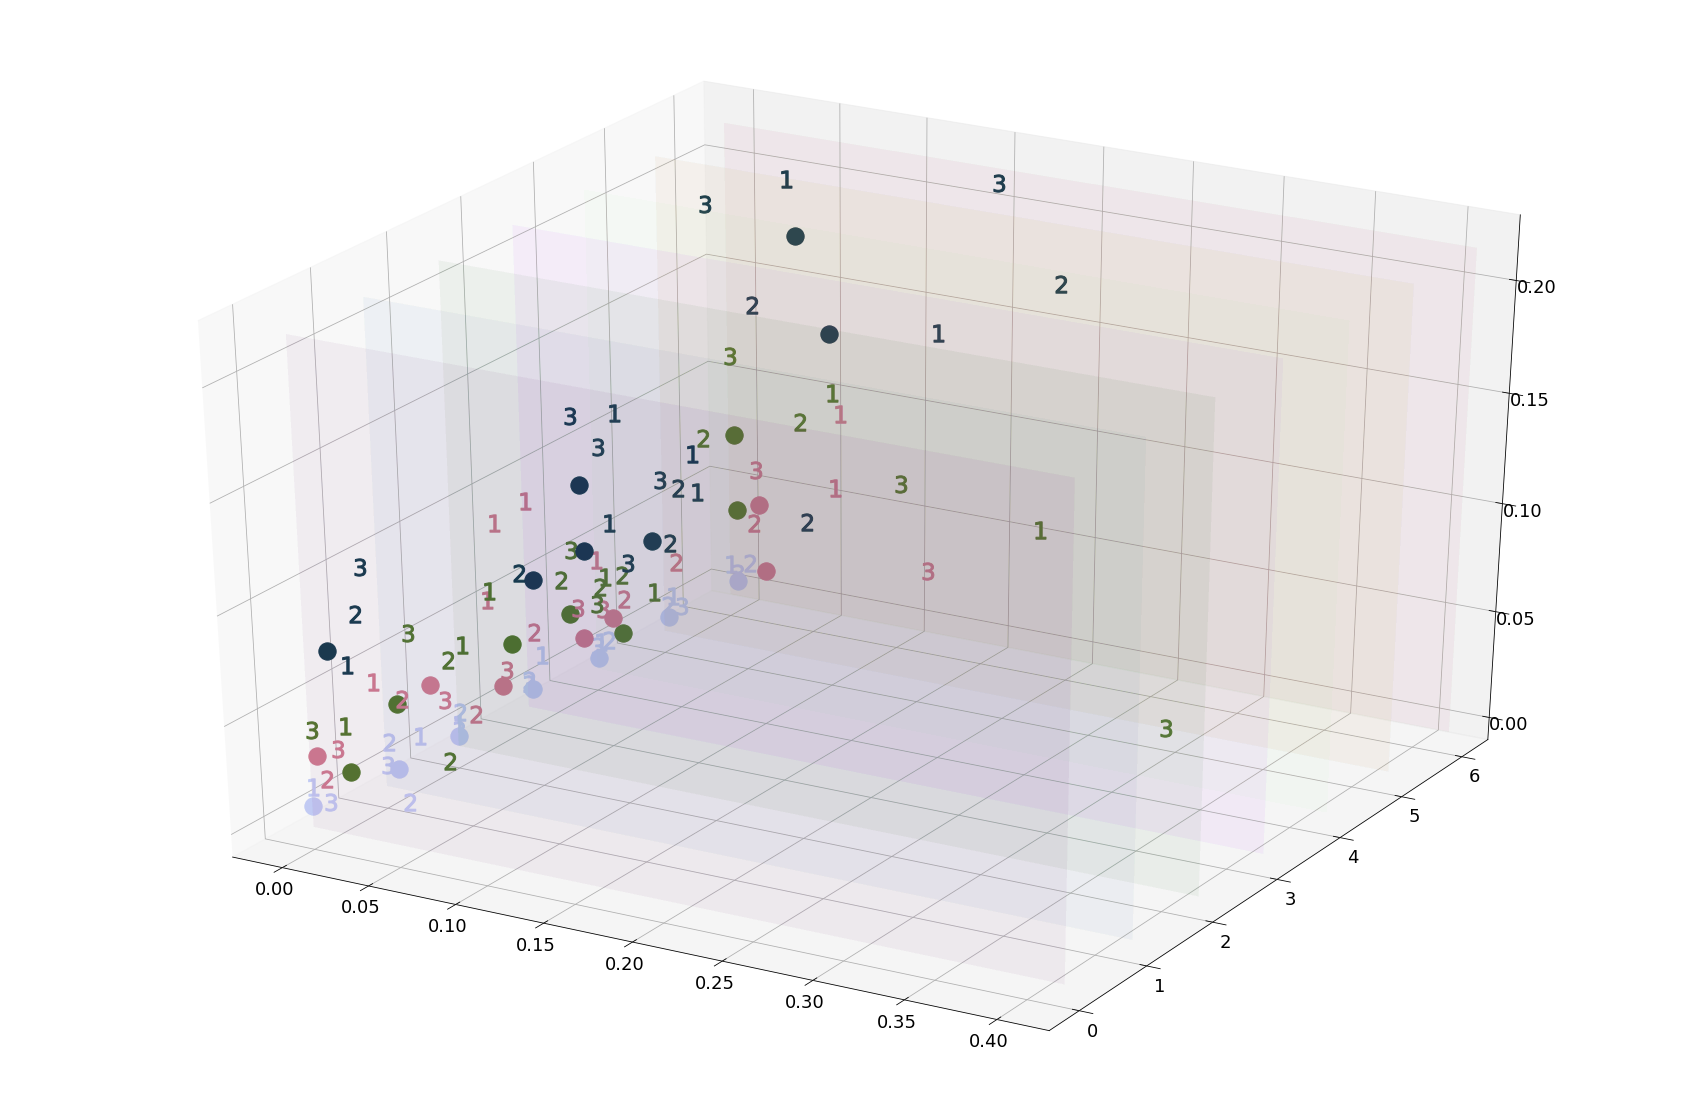

In [324]:
markers=['o', '$1$', '$2$','$3$']

plt.figure('SPLTV',figsize=(30,20))

custom=plt.subplot(projection='3d')

markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)

for n in np.arange(len(network_list)):
    for e, c in enumerate(conditions):
        for i in np.arange(4):
            custom.scatter(hills_ns[n, e, i], n, maxs_ns[n, e, i], 
                        marker=markers[i], s=300, color=colors[e])


for n in np.arange(len(network_list)):
    for e, c in enumerate(conditions):
        # 1. create vertices from points
        verts = [[(0.42, n, 0), (.42, n, 0.22), (0, n, 0.22), (0, n, 0),]]
        #verts = [list(zip(hills_ns[n, e], [n]*4, maxs_ns[n, e]))]
        # 2. create 3d polygons and specify parameters
        srf = Poly3DCollection(verts, alpha=.01, facecolor=color_stacked[n])
        # 3. add polygon to the figure (current axes)
        plt.gca().add_collection3d(srf)

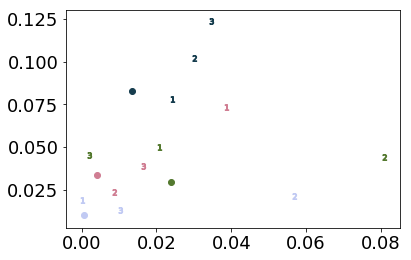

In [256]:
fig = plt.figure()
ax = fig.add_subplot(111)
markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)
for e, c in enumerate(conditions):
    for i in np.arange(4):
        plt.scatter(hills_ns[e, 6, i],maxs_ns[e, 6, i], 
                    marker=markers[i], color=colors[e])

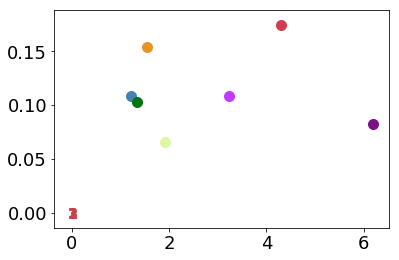

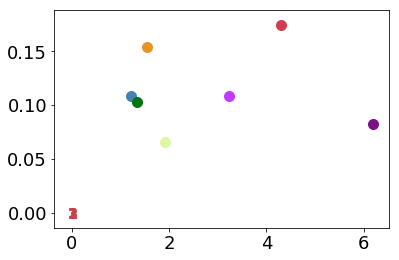

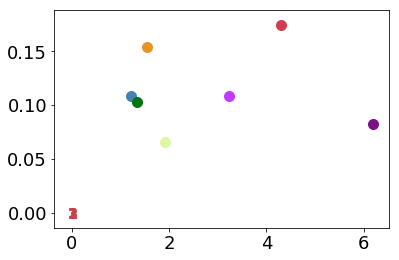

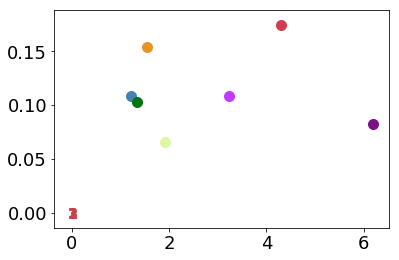

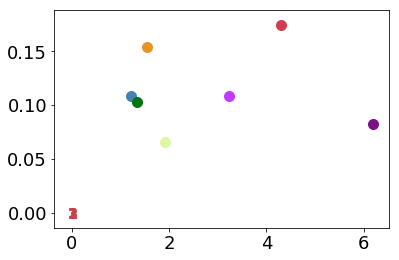

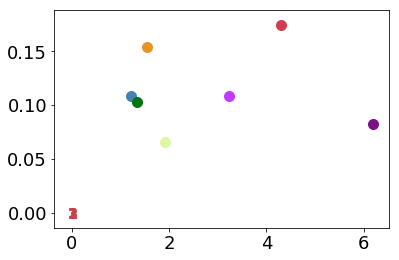

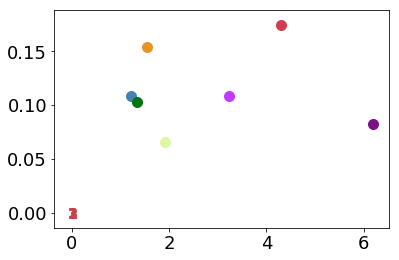

In [183]:

fig = plt.figure()
ax = fig.add_subplot(111)
markers=['o', '$1$', '$2$','$3$']

#ax.plot(hill[1:],maxs[1:],spearmans[1:],'x-')
for n in np.arange(len(network_list)):
    for i in np.arange(4):
    
        plt.scatter(hill_all[n, i],maxs_all[n, i], 
                   marker=markers[i], s=100, color=color_stacked[n])


In [181]:
conditions = ['intact', 'paragraph', 'word', 'rest']

for i in np.arange(1, 4):
    
    full_data_temp = full_data[full_data['third']==i-1]

    for e, c in enumerate(conditions):


        ydata = full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
        xdata = np.array(full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().index)

        popt, pcov = curve_fit(func, xdata, ydata, maxfev=4000)

        hill_all[e, 0, i] = popt[1]

        maxs_all[e, 0, i] = ydata.max()


KeyError: 'third'

In [146]:
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [164]:
spearmans_all

array([[0.8, 0.8, 1. , 1. ],
       [0.8, 0.8, 1. , 1. ],
       [1. , 0.8, 1. , 1. ],
       [1. , 0.8, 1. , 1. ],
       [0.8, 0.8, 1. , 1. ],
       [1. , 0.8, 1. , 1. ],
       [1. , 1. , 1. , 1. ]])

IndexError: index 4 is out of bounds for axis 0 with size 4

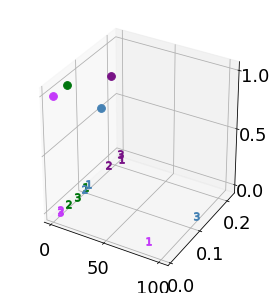

In [279]:
markers=['o', '$1$', '$2$','$3$']

plt.figure('SPLTV',figsize=(10,5))

custom=plt.subplot(121,projection='3d')

#custom.plot(hill[1:],maxs[1:],spearmans[1:],'x-', color='black')

for n in np.arange(len(network_list)):
    for i in np.arange(4):
    
        custom.scatter(hill_all[n, i],maxs_all[n, i],spearmans_all[n, i], 
                   marker=markers[i], s=60, color=color_stacked[n])
    
#for n in np.arange(len(network_list)):
for n in [6]:
    # 1. create vertices from points
    verts = [list(zip(hill_all[n], maxs_all[n], spearmans_all[n]))]
    # 2. create 3d polygons and specify parameters
    srf = Poly3DCollection(verts, alpha=.25, facecolor=color_stacked[n])
    # 3. add polygon to the figure (current axes)
    plt.gca().add_collection3d(srf)

In [150]:
hill_all[n]

array([1.33388063, 1.28667462, 0.90163269, 1.74338874])

In [144]:
hill_all[0]

array([6.19283593, 3.23961345, 3.41827515, 3.5769618 ])

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Visual.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Visual.csv']
Visual
1


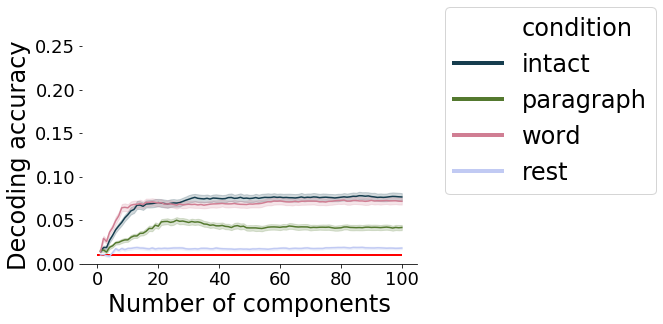

Visual
2


<Figure size 432x288 with 0 Axes>

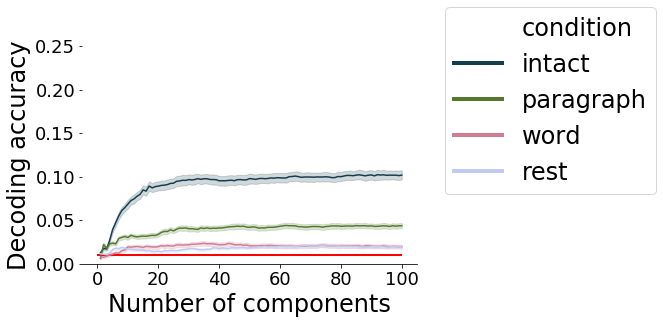

Visual
3


<Figure size 432x288 with 0 Axes>

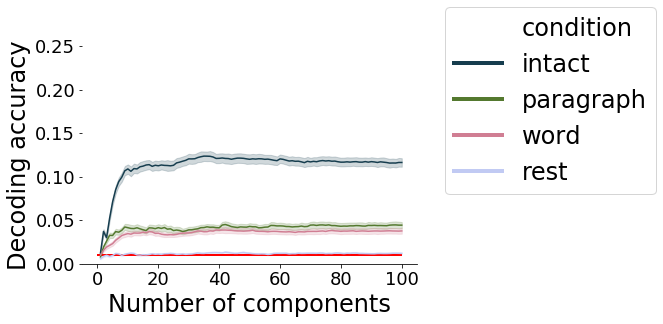

<Figure size 432x288 with 0 Axes>

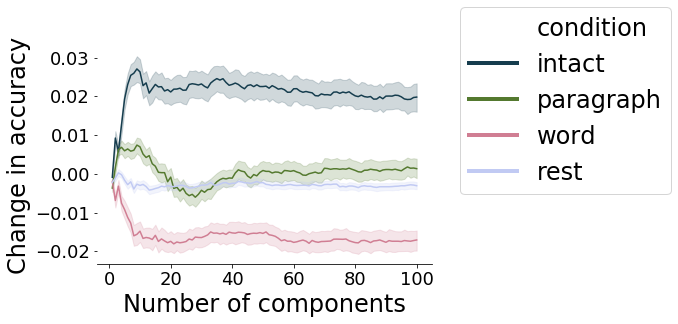

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Somatomotor.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Somatomotor.csv']
Somatomotor
1


<Figure size 432x288 with 0 Axes>

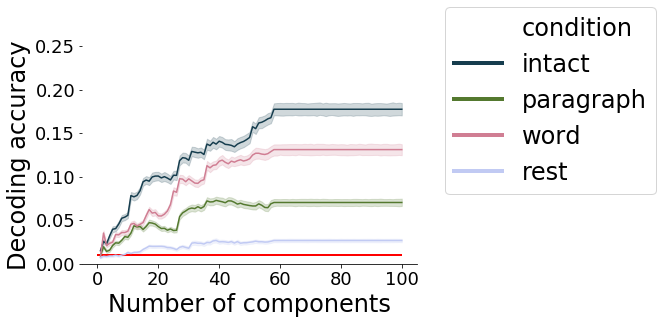

Somatomotor
2


<Figure size 432x288 with 0 Axes>

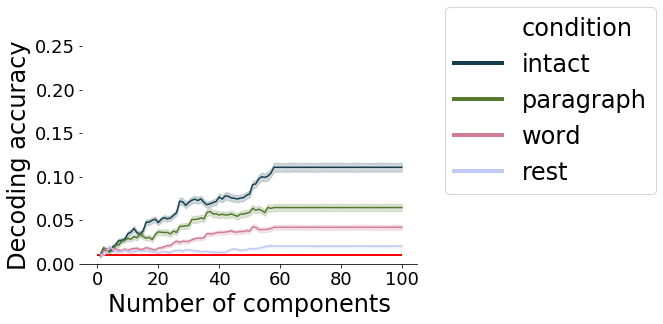

Somatomotor
3


<Figure size 432x288 with 0 Axes>

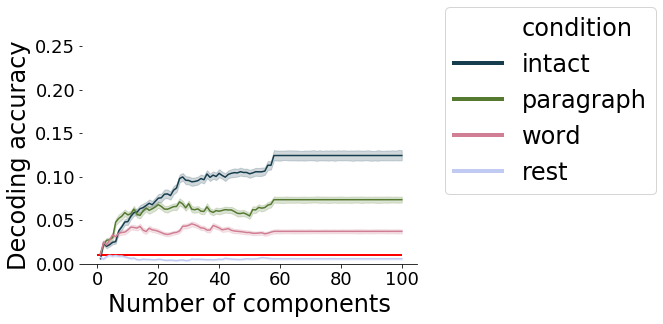

<Figure size 432x288 with 0 Axes>

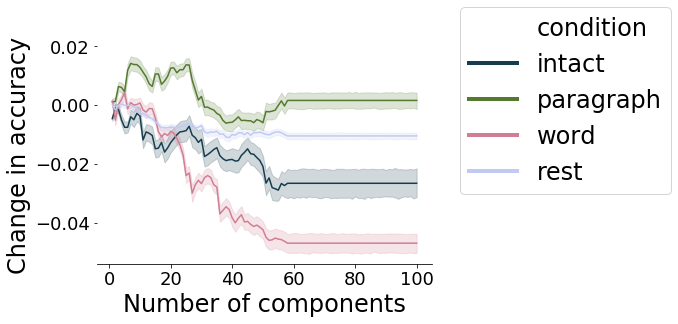

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Dorsal Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Dorsal Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Dorsal Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Dorsal Attention.csv']
Dorsal Attention
1


<Figure size 432x288 with 0 Axes>

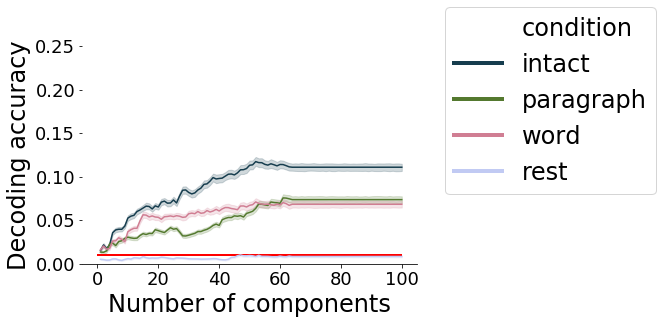

Dorsal Attention
2


<Figure size 432x288 with 0 Axes>

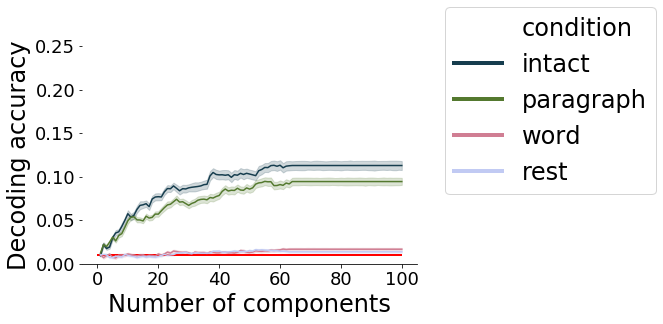

Dorsal Attention
3


<Figure size 432x288 with 0 Axes>

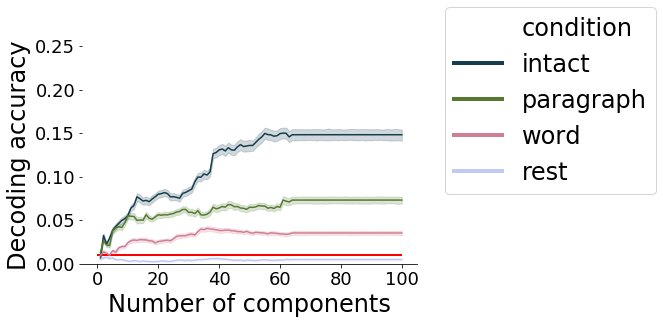

<Figure size 432x288 with 0 Axes>

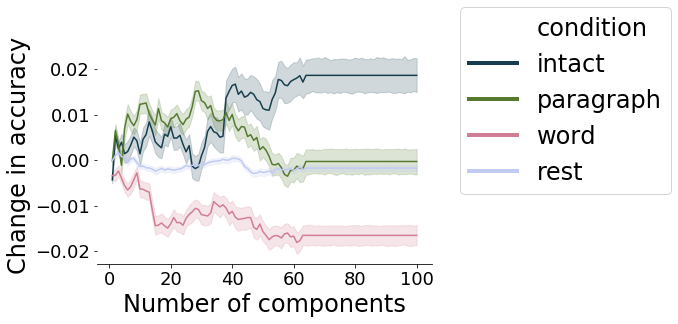

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Ventral Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Ventral Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Ventral Attention.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Ventral Attention.csv']
Ventral Attention
1


<Figure size 432x288 with 0 Axes>

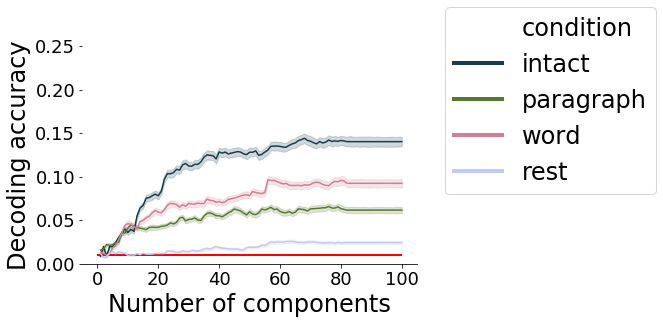

Ventral Attention
2


<Figure size 432x288 with 0 Axes>

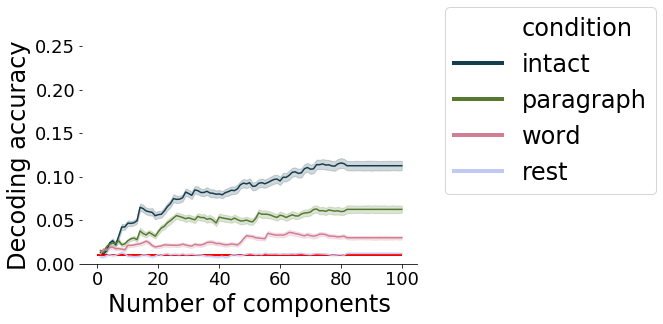

Ventral Attention
3


<Figure size 432x288 with 0 Axes>

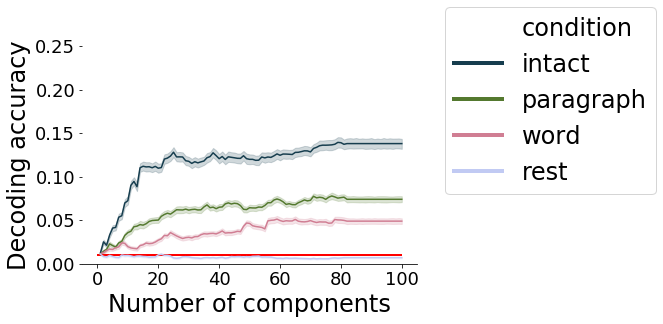

<Figure size 432x288 with 0 Axes>

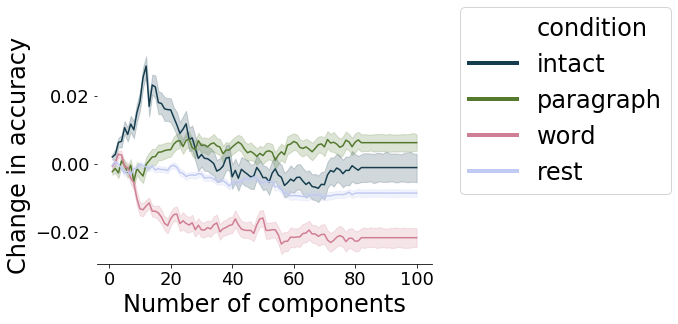

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Limbic .csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Limbic .csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Limbic .csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Limbic .csv']
Limbic 
1


<Figure size 432x288 with 0 Axes>

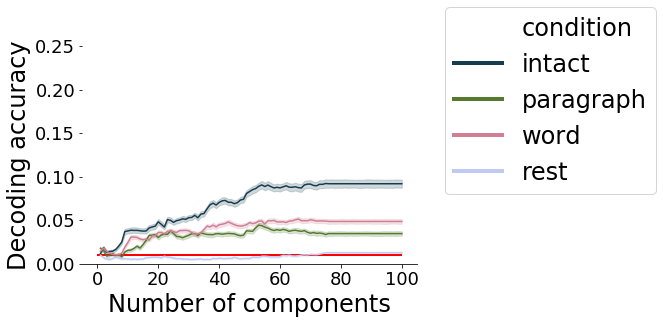

Limbic 
2


<Figure size 432x288 with 0 Axes>

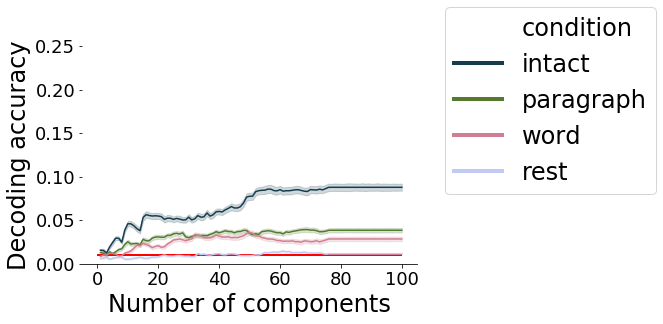

Limbic 
3


<Figure size 432x288 with 0 Axes>

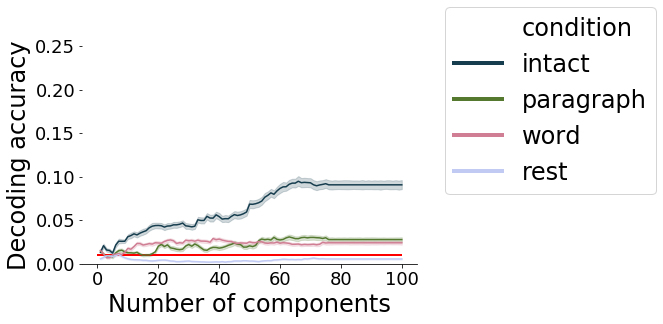

<Figure size 432x288 with 0 Axes>

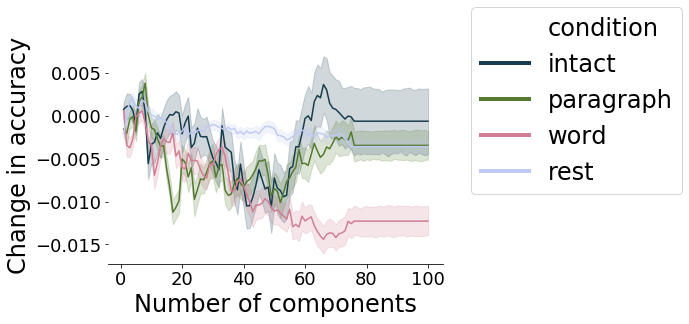

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Frontoparietal.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Frontoparietal.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Frontoparietal.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Frontoparietal.csv']
Frontoparietal
1


<Figure size 432x288 with 0 Axes>

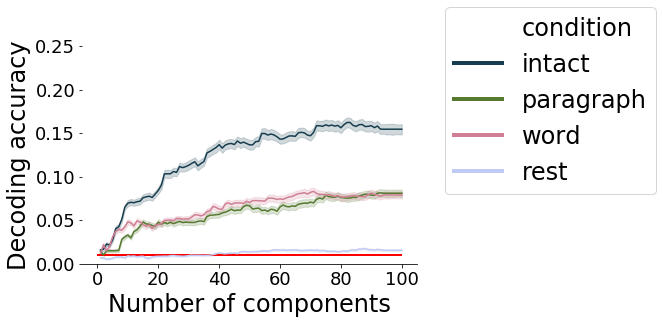

Frontoparietal
2


<Figure size 432x288 with 0 Axes>

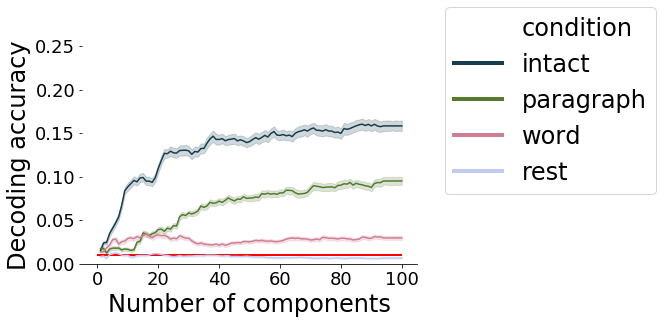

Frontoparietal
3


<Figure size 432x288 with 0 Axes>

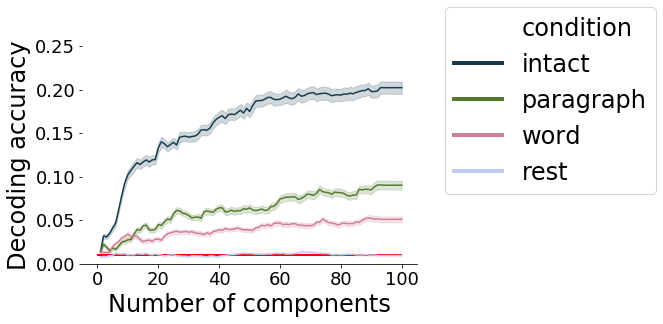

<Figure size 432x288 with 0 Axes>

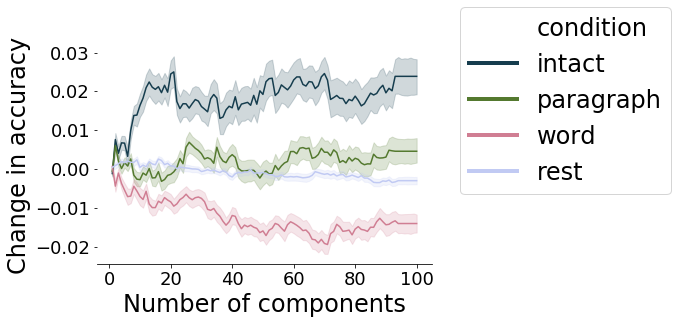

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/intact_Default.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/paragraph_Default.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/rest_Default.csv', '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_network_chunked/PCA/ndims_100/word_Default.csv']
Default
1


<Figure size 432x288 with 0 Axes>

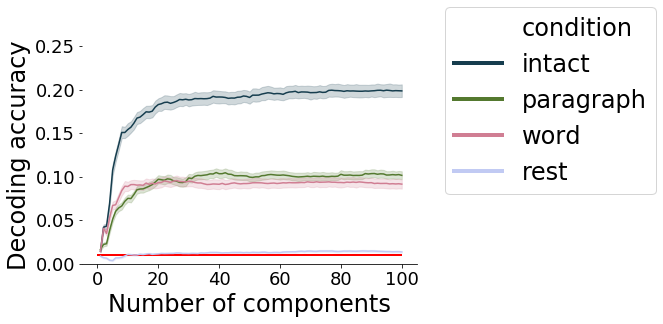

Default
2


<Figure size 432x288 with 0 Axes>

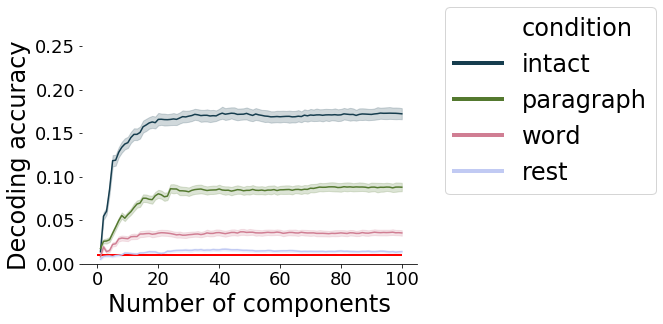

Default
3


<Figure size 432x288 with 0 Axes>

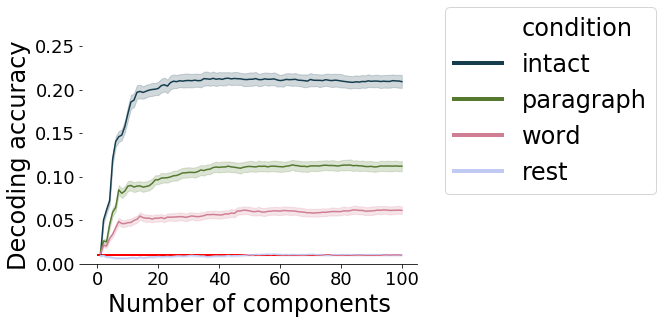

<Figure size 432x288 with 0 Axes>

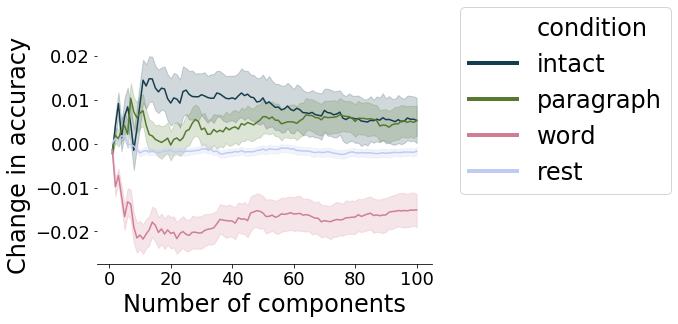

<Figure size 432x288 with 0 Axes>

In [34]:
for n in np.arange(len(network_list)):
    conds =glob.glob(os.path.join(resultsdir, '*' + network_list[n] + '.csv'))
    print(conds)
    full_data = pd.DataFrame()
    for c in conds:
        data = pd.read_csv(c)
        data['condition'] = os.path.basename(os.path.splitext(c)[0]).split("_", 1)[0]

        if full_data.empty:
            full_data = data
        else:
            full_data = full_data.append(data)
            
    for i in range(3):
        print(network_list[n])
        print(i+1)
        outfile = os.path.join(figdir, 'Accuracy_by_components_' + network_list[n] + '_third_' + str(i) + '.pdf')
        fig, ax = plt.subplots()
        sns.lineplot(x="dims", y="accuracy",
                     hue="condition",
                     data=full_data[full_data['third']==i], ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
        sns.despine(ax=ax, left=True)
        #ax.set_title('Accuracy by components for third: ' + str(i + 1))
        ax.set_ylabel('Decoding accuracy',fontsize=24)
        ax.set_xlabel('Number of components',fontsize=24)
        ax.set_ylim(0, .25)
        ax.hlines(y=1/100, xmin=0, xmax=100, linewidth=2, color='r')
        l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
        for line in l.get_lines():
            line.set_linewidth(4.0)
        #fig.savefig(outfile, bbox_inches='tight')
        plt.show()
        plt.clf()
        
    data_regression = full_data.groupby(['iteration', 'folds', 'condition', 'dims'], 
                           group_keys=False).apply(regress, 'accuracy', ['third']).reset_index()
    outfile = os.path.join(figdir, 'Changes_across_thirds.pdf')

    fig, ax = plt.subplots()
    sns.lineplot(x="dims", y="third",
                 hue="condition",
                 data=data_regression, palette="cubehelix", 
               hue_order=['intact', 'paragraph', 'word', 'rest'])
    sns.despine(ax=ax, left=True)
    #ax.set_title('Accuracy by components for third: ' + str(i + 1))
    ax.set_ylabel('Change in accuracy',fontsize=24)
    ax.set_xlabel('Number of components',fontsize=24)

    l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    for line in l.get_lines():
        line.set_linewidth(4.0)
    #fig.savefig(outfile, bbox_inches='tight')
    plt.show()
    plt.clf()

In [35]:
full_data[full_data['condition']=='intact'].head()

Unnamed: 0    rank  accuracy   error  dims  folds  iteration  third  \
0           0  0.7788      0.01  0.4544     1      0          0      0   
1           0  0.7950      0.03  0.2493     2      0          0      0   
2           0  0.8110      0.02  0.3277     3      0          0      0   
3           0  0.8821      0.05  0.2320     4      0          0      0   
4           0  0.9294      0.10  0.1760     5      0          0      0   

  condition  
0    intact  
1    intact  
2    intact  
3    intact  
4    intact

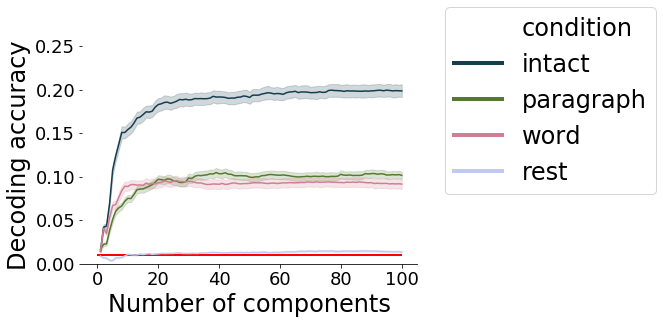

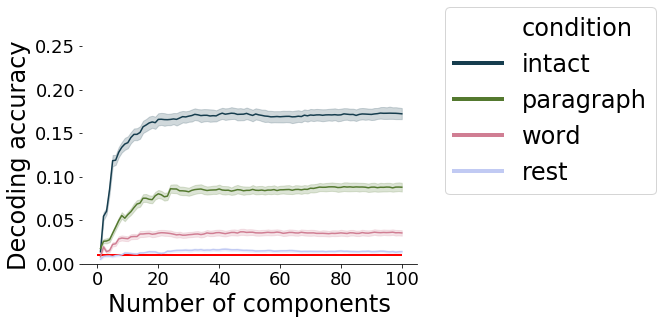

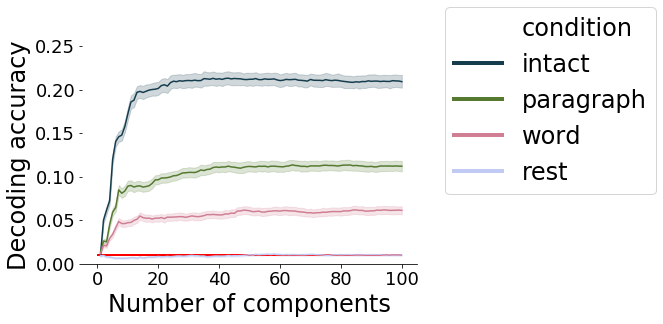

In [36]:
for i in range(3):
    outfile = os.path.join(figdir, 'Accuracy_by_components_third_' + str(i) + '.pdf')
    fig, ax = plt.subplots()
    sns.lineplot(x="dims", y="accuracy",
                 hue="condition",
                 data=full_data[full_data['third']==i], ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
    sns.despine(ax=ax, left=True)
    #ax.set_title('Accuracy by components for third: ' + str(i + 1))
    ax.set_ylabel('Decoding accuracy',fontsize=24)
    ax.set_xlabel('Number of components',fontsize=24)
    ax.set_ylim(0, .25)
    ax.hlines(y=1/100, xmin=0, xmax=100, linewidth=2, color='r')
    l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    for line in l.get_lines():
        line.set_linewidth(4.0)
    fig.savefig(outfile, bbox_inches='tight')
    

In [37]:
data_regression = full_data.groupby(['iteration', 'folds', 'condition', 'dims'], 
                           group_keys=False).apply(regress, 'accuracy', ['third']).reset_index()

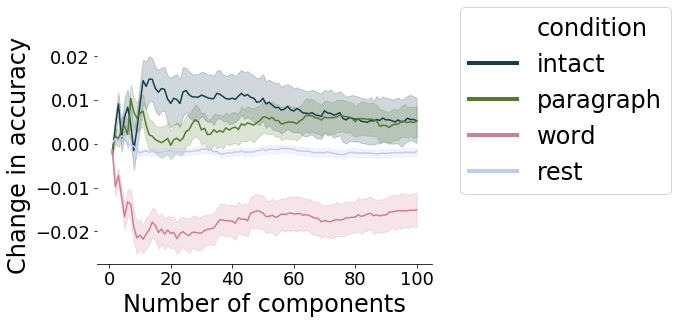

In [38]:
outfile = os.path.join(figdir, 'Changes_across_thirds.pdf')

fig, ax = plt.subplots()
sns.lineplot(x="dims", y="third",
             hue="condition",
             data=data_regression, palette="cubehelix", 
           hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.despine(ax=ax, left=True)
#ax.set_title('Accuracy by components for third: ' + str(i + 1))
ax.set_ylabel('Change in accuracy',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)

l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
for line in l.get_lines():
    line.set_linewidth(4.0)
fig.savefig(outfile, bbox_inches='tight')

In [39]:
# for i in range(3):
#     full_data_temp = full_data[full_data['third']==i].reset_index(drop=True)
#     full_data_temp['diff'] = full_data_temp.groupby(['condition', 'iteration', 'folds'])['accuracy'].diff(5)/5
#     fig, ax = plt.subplots()
#     sns.lineplot(x="dims", y="diff",
#              hue="condition",
#              data=full_data_temp, palette="cubehelix", 
#            hue_order=['intact', 'paragraph', 'word', 'rest'])
#     sns.despine(ax=ax, left=True)
#     ax.set_title('Accuracy by components')
#     ax.set_ylabel('Decoding accuracy',fontsize=24)
#     ax.set_xlabel('Number of components',fontsize=24)
#     ax.set_ylim(0, .03)
#     ax.set_xlim(5, 100)
#     #ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
#     #ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
#     l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
#     for line in l.get_lines():
#         line.set_linewidth(4.0)
#     fig.savefig(outfile, bbox_inches='tight')
#     plt.show()
#     plt.clf()
# #     lm = sns.lmplot(x="dims", y="diff",
# #              hue="condition",
# #              data=full_data, scatter_kws={"alpha":0.0,"s":20}, ci=95, palette="cubehelix", logistic=True, 
# #            hue_order=['intact', 'paragraph', 'word', 'rest'])
# #     axes = lm.axes
# #     axes[0,0].set_ylim(0,.02)
# #     axes[0,0].set_xlim(1,100)

In [40]:
# for i in range(3):
#     full_data_temp = full_data[full_data['third']==i].reset_index(drop=True)
#     full_data_temp['diff'] = full_data_temp.groupby(['condition', 'iteration', 'folds'])['accuracy'].diff(2)/2
# #     sns.lineplot(x="dims", y="diff",
# #              hue="condition",
# #              data=full_data_temp, palette="cubehelix", 
# #            hue_order=['intact', 'paragraph', 'word', 'rest'])
    
#     lm = sns.lmplot(x="dims", y="diff",
#              hue="condition", data=full_data_temp, scatter_kws={"alpha":0.0,"s":20}, ci=95, palette="cubehelix", logistic=True, 
#            hue_order=['intact', 'paragraph', 'word', 'rest'])
#     axes = lm.axes
#     axes[0,0].set_ylim(0,.025)
#     axes[0,0].set_xlim(3,100)
#     plt.show()
#     plt.clf()